# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [3]:
Mode2 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode2/Mode2.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode2.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
GLOBAL_SAVE_CALIBRATE = true;

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [5]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-11-08 16:31:46] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


[2024-11-08 16:31:58] Info: Done With Floquet Sweep
[2024-11-08 16:31:59] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0003603408193151533	 0.008952916310483644	 2.0067079850950655
Stark shift res: [0.0003603408193151533, 55.66103739557934]


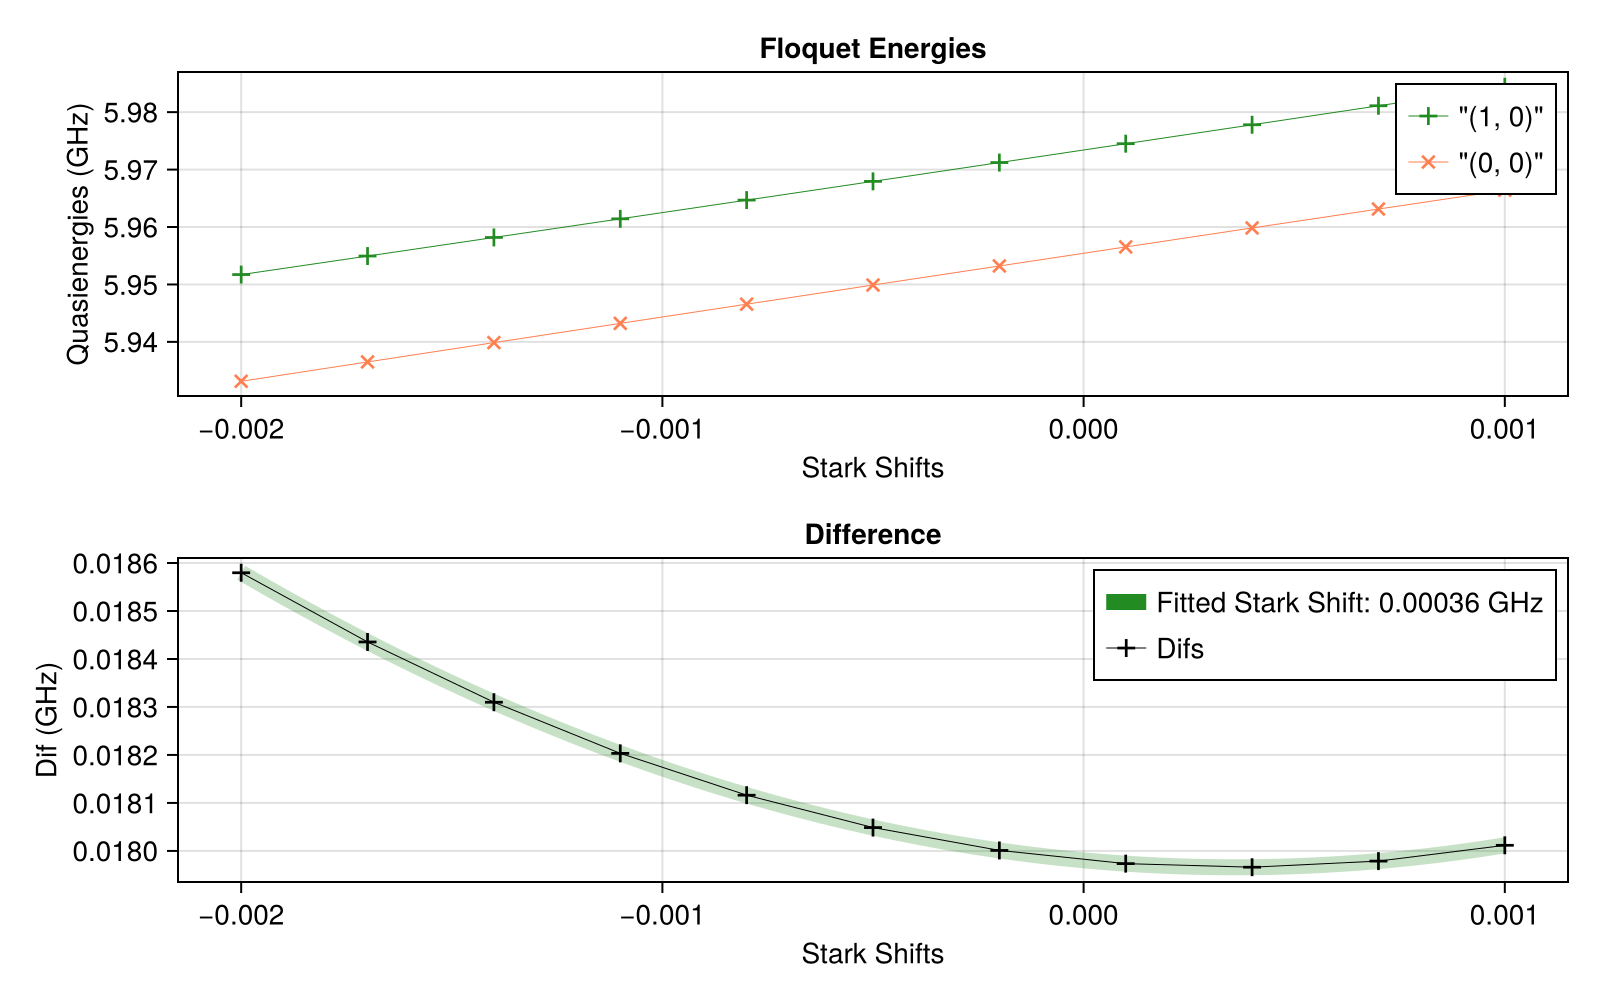

In [6]:
ge_ε = 0.00538
drive_op = Mode2.n̂ₜ
state1 = (0,0)
state2 = (1,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode2, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $|1,0\rangle+|0,1\rangle \to |0,0\rangle+|1,1\rangle$

In [7]:

ψ1 = Mode2.dressed_states[(1,0)]+Mode2.dressed_states[(0,1)]
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode2.dressed_states[(0,0)]+Mode2.dressed_states[(1,1)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d_e0 = Mode2.dressed_energies[(1,0)]-Mode2.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode2.dressed_energies[(1,1)]-Mode2.dressed_energies[(0,1)]+ge_stark_shift

freq_d = (freq_d_e0+freq_d_g1)/2

check_op = proj_dict[(0,0)]+proj_dict[(1,1)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

#qubit_ε = qubit_ε

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_half = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-08 16:32:11] Info: On Level 1
[2024-11-08 16:32:11] Info: On Step 1: t = 90.0
[2024-11-08 16:32:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:32:16] Info: Time Evolution Complete
[2024-11-08 16:32:16] Info: Done with Level_1_step_1
[2024-11-08 16:32:16] Info: Using Check Op
[2024-11-08 16:32:16] Info: Accurace: 0.9967459398910934
[2024-11-08 16:32:16] Info: ------------------------------------------------------------------------------
[2024-11-08 16:32:16] Info: On Step 2: t = 92.5
[2024-11-08 16:32:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 16:32:17] Info: Time Evolution Complete
[2024-11-08 16:32:17] Info: Done with Level_1_step_2
[2024-11-08 16:32:17] Info: Using Check Op
[2024-11-08 16:32:17] Info: Accurace: 0.9992010948918311
[2024-11-08 16:32:17] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99928
  "freq_d"        => 4.60405

In [8]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ge_1/2"] = deepcopy(qubit_ge_half)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99928
  "freq_d"        => 4.60405

In [9]:
ψ = Mode2.dressed_states[(1,0)]+Mode2.dressed_states[(0,1)]
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_half_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ge_1/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:33:17.412
It is being saved at: Data/
[2024-11-08 16:33:17] Info: Running operator q_ge_1/2
[2024-11-08 16:33:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 08s (ETA: 0h 00m 00s)
[2024-11-08 16:33:25] Info: Time Evolution Complete
[2024-11-08 16:33:25] Info: Saving Steps
[2024-11-08 16:33:35] Info: Done with Step_1
[2024-11-08 16:33:35] Info: Done With Running Sequence
[2024-11-08 16:33:35] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [10]:
EVs = SC.Utils.Get_EVs(q_ge_half_res["states"], proj_dict);

[2024-11-08 16:33:40] Info: Making Plot


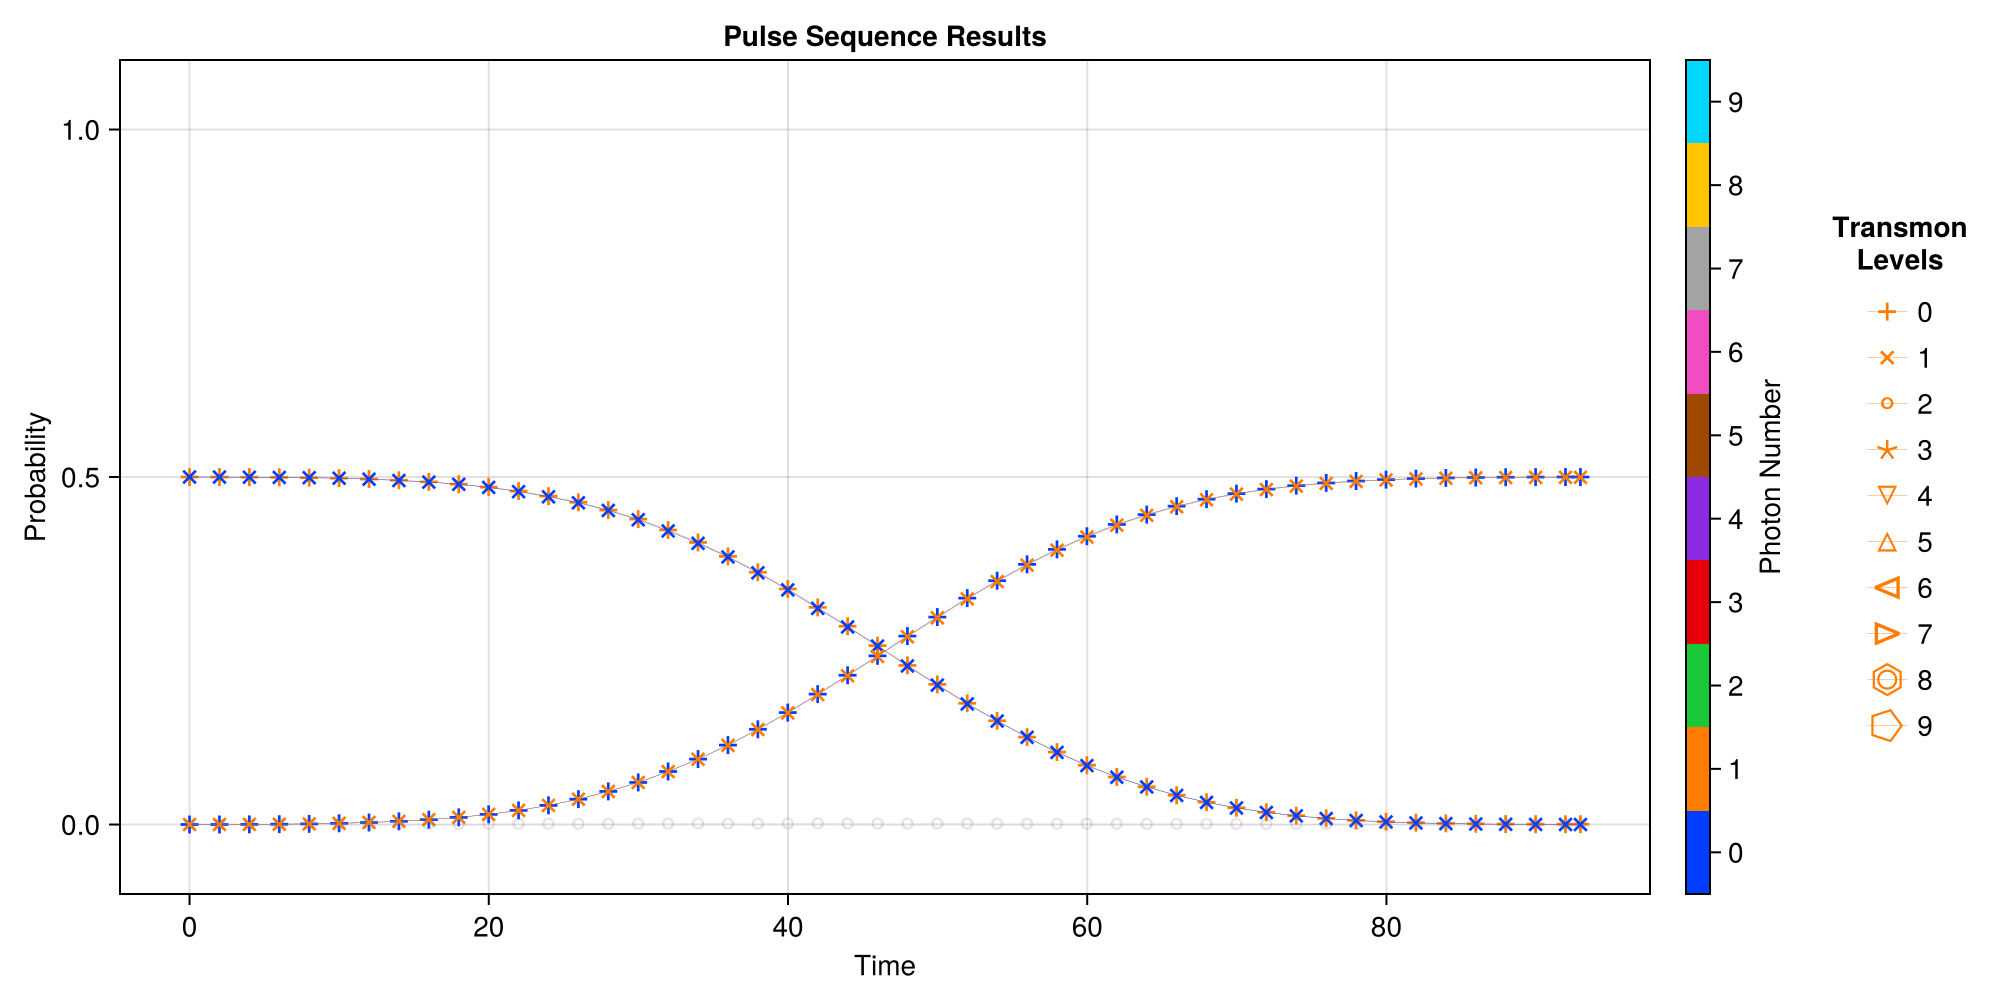

CairoMakie.Screen{IMAGE}


In [11]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ge_half_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1)])

In [12]:
println(EVs[(0,0)][end])
println(EVs[(1,1)][end])

0.4999682841591561 - 4.866683513394815e-18im
0.49952627035053443 - 1.544175426190759e-17im


In [13]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997253253903 - 2.022759970276331e-17im

#### $|0,0\rangle \to |1,0\rangle$

In [14]:
state1 = (0,0)
state2 = (1,0)
ψ1 = Mode2.dressed_states[state1]
ψ2 = Mode2.dressed_states[state2]

freq_d = Mode2.dressed_energies[state2]-Mode2.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge0_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 16:33:48] Info: On Level 1
[2024-11-08 16:33:48] Info: On Step 1: t = 90.0
[2024-11-08 16:33:48] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:33:52] Info: Time Evolution Complete
[2024-11-08 16:33:52] Info: Done with Level_1_step_1
[2024-11-08 16:33:52] Info: Accurace: 0.9968466842437986
[2024-11-08 16:33:52] Info: ------------------------------------------------------------------------------
[2024-11-08 16:33:52] Info: On Step 2: t = 92.5
[2024-11-08 16:33:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:33:56] Info: Time Evolution Complete
[2024-11-08 16:33:56] Info: Done with Level_1_step_2
[2024-11-08 16:33:56] Info: Accurace: 0.9992955278869792
[2024-11-08 16:33:56] Info: ------------------------------------------------------------------------------
[2024-11-08 16:33:56] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999357
  "freq_d"        => 4.60416

In [15]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge0_opt_res)
end


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999357
  "freq_d"        => 4.60416

In [16]:
ψ = Mode2.dressed_states[(0,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge0_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ge_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:35:27.155
It is being saved at: Data/
[2024-11-08 16:35:27] Info: Running operator q_ge_0
[2024-11-08 16:35:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:35:30] Info: Time Evolution Complete
[2024-11-08 16:35:30] Info: Saving Steps
[2024-11-08 16:35:31] Info: Done with Step_1
[2024-11-08 16:35:31] Info: Done With Running Sequence
[2024-11-08 16:35:31] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [17]:
EVs_ge0 = SC.Utils.Get_EVs(q_ge0_res["states"], proj_dict);

[2024-11-08 16:35:31] Info: Making Plot


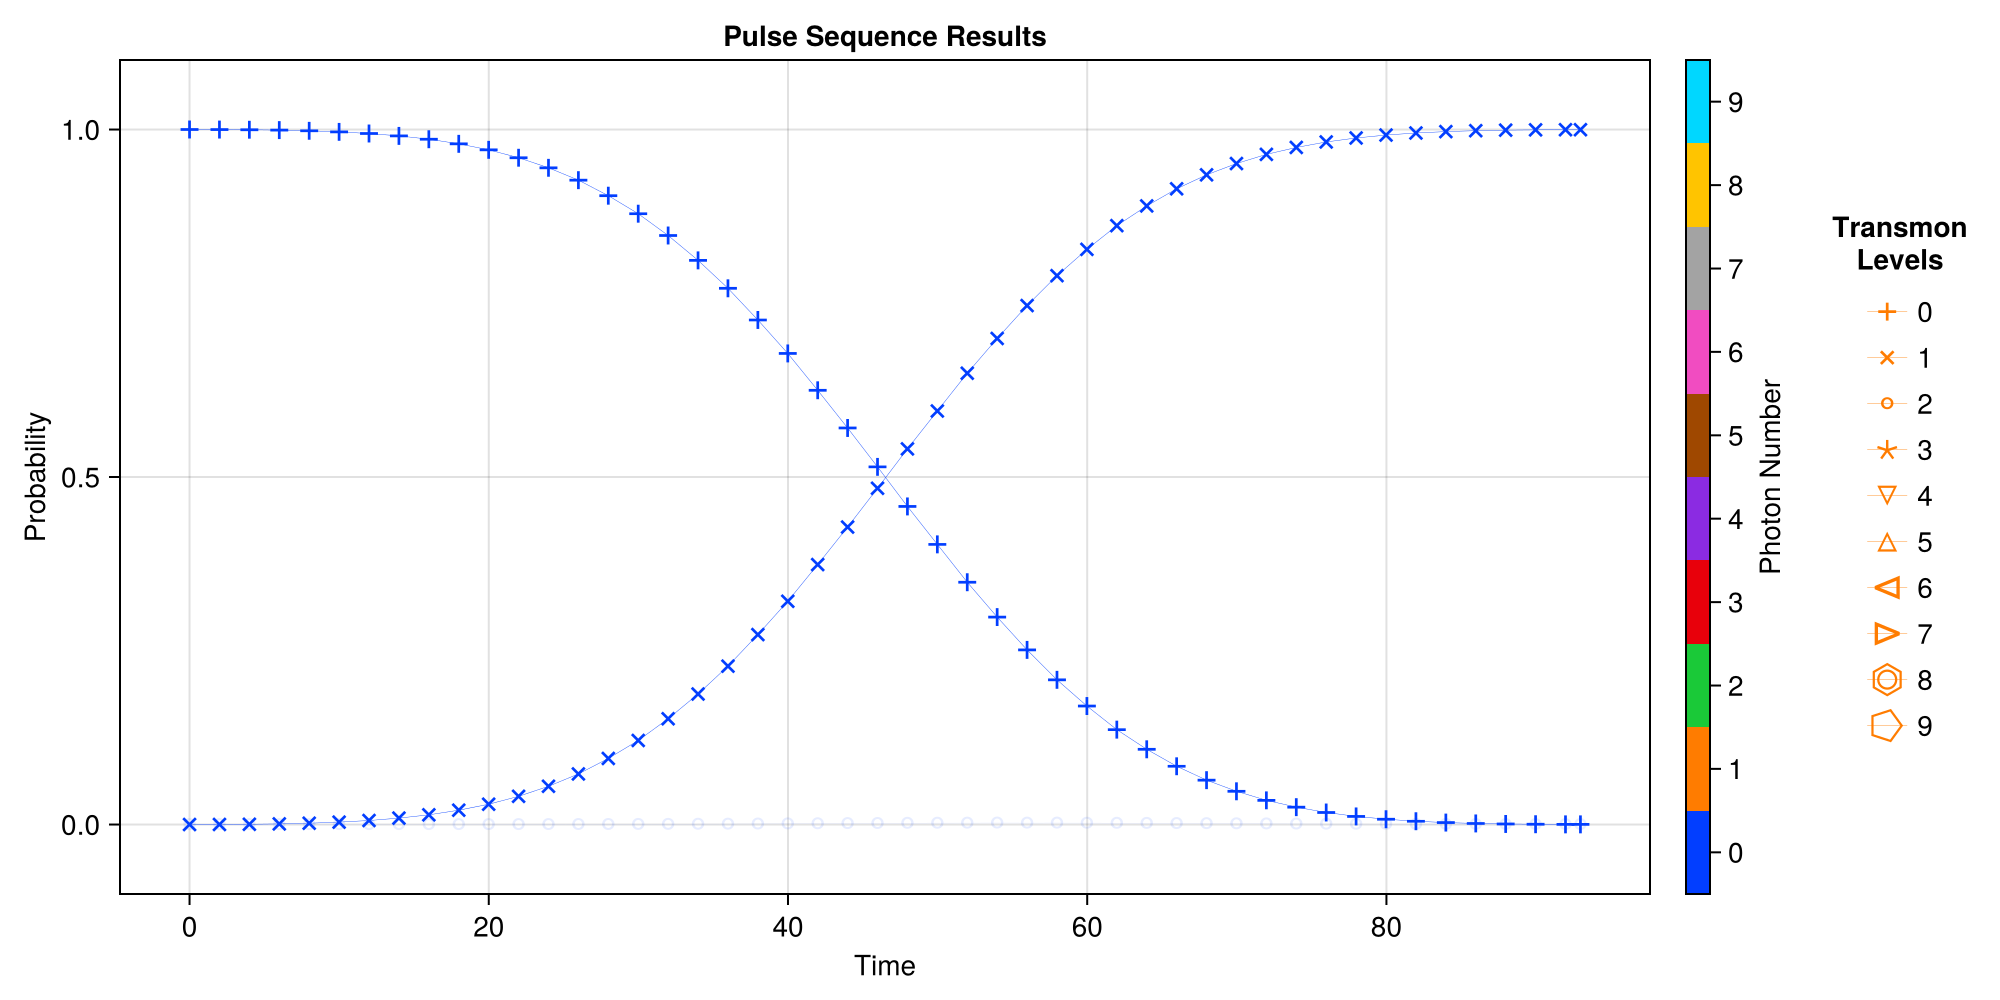

CairoMakie.Screen{IMAGE}


In [18]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ge0_res["times"], EVs_ge0, plot_every = 10, emph_states = [(0,0),(1,0)])

In [19]:
println(EVs_ge0[(0,0)][end])
println(EVs_ge0[(1,0)][end])
println(EVs_ge0[(2,0)][end])

0.00022560746588831592 - 3.593742175433756e-21im
0.9997119489701378 - 4.567470992632992e-18im
6.20381120464439e-5 + 1.8194726850999695e-22im


In [20]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997253253903 - 2.022759970276331e-17im

#### $|0,1\rangle \to |1,1\rangle$

In [21]:
state1 = (0,1)
state2 = (1,1)
ψ1 = Mode2.dressed_states[state1]
ψ2 = Mode2.dressed_states[state2]

freq_d = Mode2.dressed_energies[state2]-Mode2.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge1_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 16:35:31] Info: On Level 1
[2024-11-08 16:35:31] Info: On Step 1: t = 90.0
[2024-11-08 16:35:31] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 16:35:33] Info: Time Evolution Complete
[2024-11-08 16:35:33] Info: Done with Level_1_step_1
[2024-11-08 16:35:33] Info: Accurace: 0.9971305299105324
[2024-11-08 16:35:33] Info: ------------------------------------------------------------------------------
[2024-11-08 16:35:33] Info: On Step 2: t = 92.5
[2024-11-08 16:35:33] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 16:35:35] Info: Time Evolution Complete
[2024-11-08 16:35:35] Info: Done with Level_1_step_2
[2024-11-08 16:35:35] Info: Accurace: 0.9996079069739323
[2024-11-08 16:35:35] Info: ------------------------------------------------------------------------------
[2024-11-08 16:35:35] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999677
  "freq_d"        => 4.60394

In [22]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ge_1"] = deepcopy(qubit_ge1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999677
  "freq_d"        => 4.60394

In [23]:
ψ = Mode2.dressed_states[(0,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge1_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ge_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:37:21.163
It is being saved at: Data/
[2024-11-08 16:37:21] Info: Running operator q_ge_1
[2024-11-08 16:37:21] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:37:25] Info: Time Evolution Complete
[2024-11-08 16:37:25] Info: Saving Steps
[2024-11-08 16:37:26] Info: Done with Step_1
[2024-11-08 16:37:26] Info: Done With Running Sequence
[2024-11-08 16:37:26] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [24]:
EVs = SC.Utils.Get_EVs(q_ge1_res["states"], proj_dict);

[2024-11-08 16:37:27] Info: Making Plot


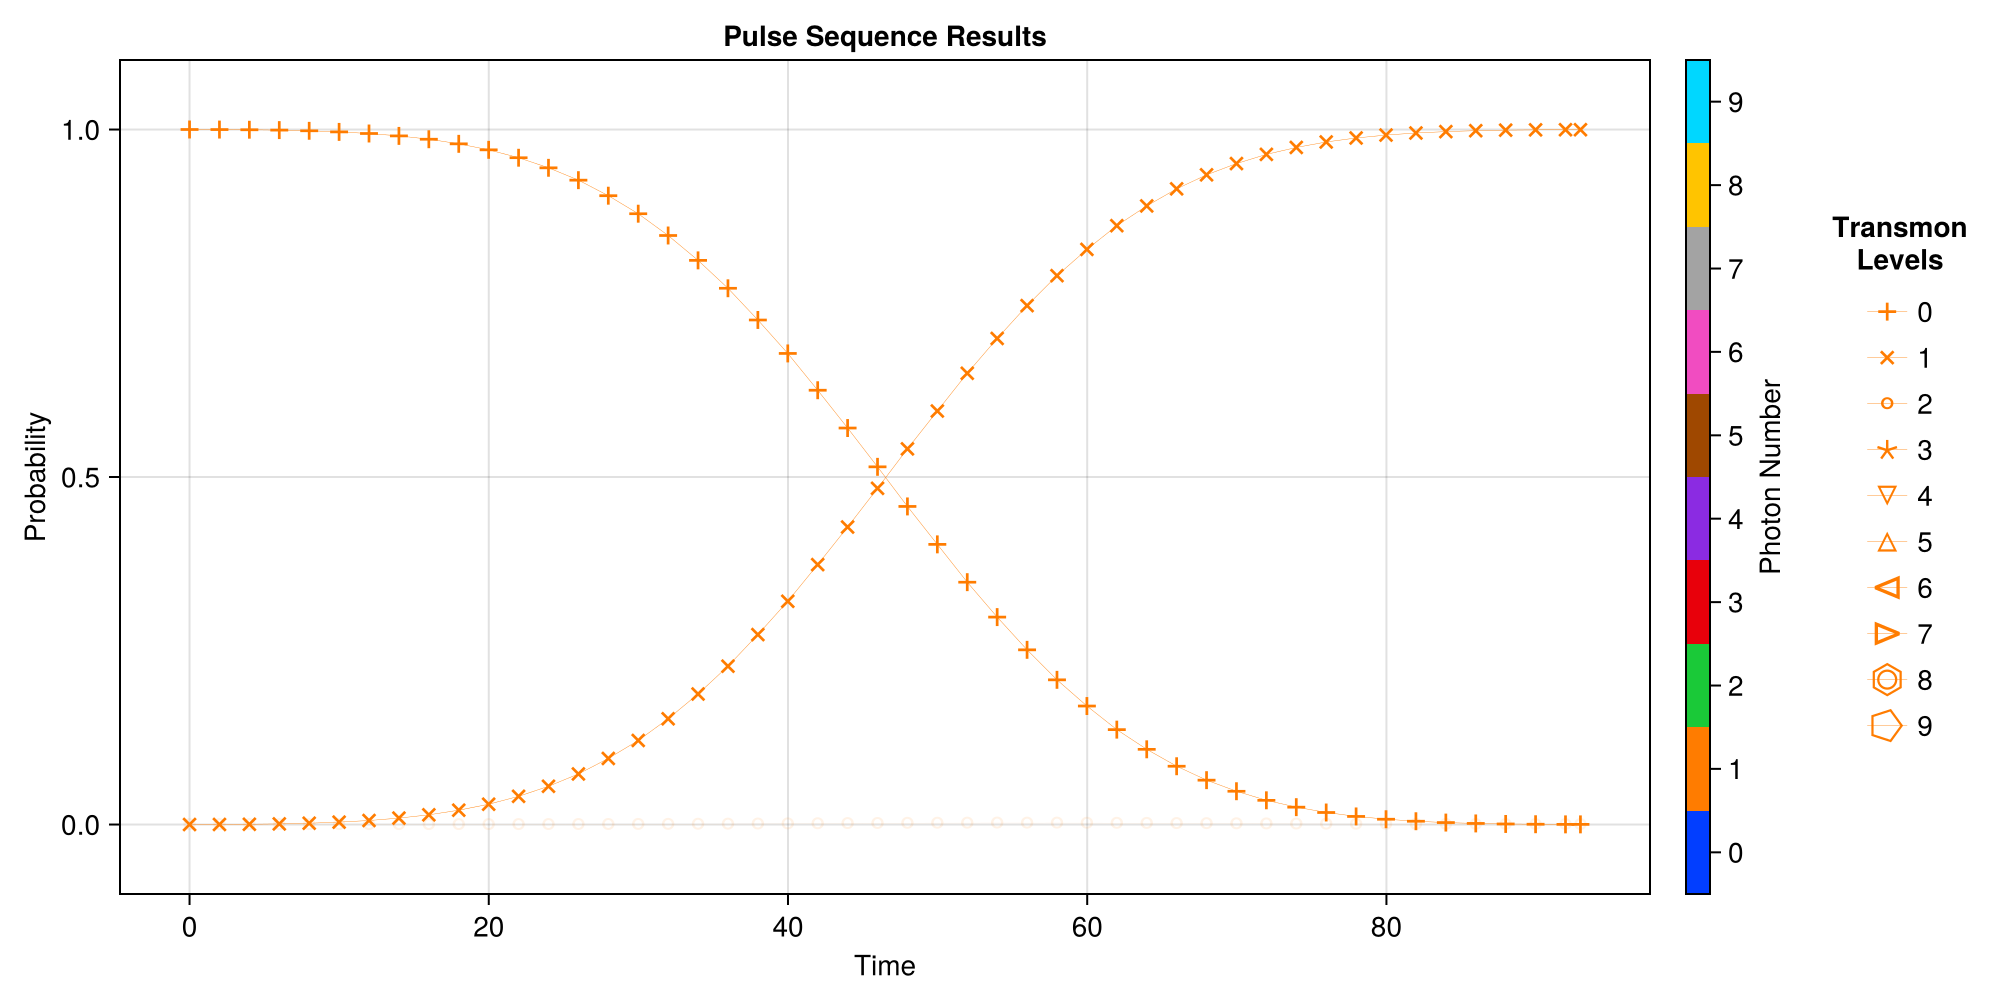

CairoMakie.Screen{IMAGE}


In [25]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ge1_res["times"], EVs, plot_every = 10, emph_states = [(0,1),(1,1)])

In [26]:
EVs[(1,1)][end]

0.9997101211944784 - 2.7037421381764522e-17im

In [27]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999975122373415 - 2.727632028123627e-17im

#### $|0,0\rangle+(|1,1\rangle+|0,3\rangle)/\sqrt{2} \to |1,0\rangle+(|0,1\rangle+|1,3\rangle)/\sqrt{2}$

In [28]:

ψ1 = Mode2.dressed_states[(0,0)]+(Mode2.dressed_states[(1,1)]+Mode2.dressed_states[(0,3)])/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode2.dressed_states[(1,0)]+(Mode2.dressed_states[(0,1)]+Mode2.dressed_states[(1,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_g0 = Mode2.dressed_energies[(1,0)]-Mode2.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode2.dressed_energies[(1,1)]-Mode2.dressed_energies[(0,1)]+ge_stark_shift
freq_d_g3 = Mode2.dressed_energies[(1,3)]-Mode2.dressed_energies[(0,3)]+ge_stark_shift

χ = freq_d_g1-freq_d_g0

freq_d = freq_d_g0+4*χ/3

check_op = proj_dict[(1,0)]+proj_dict[(0,1)]+proj_dict[(1,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_four_thirds_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-08 16:37:27] Info: On Level 1
[2024-11-08 16:37:27] Info: On Step 1: t = 90.0
[2024-11-08 16:37:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:37:31] Info: Time Evolution Complete
[2024-11-08 16:37:31] Info: Done with Level_1_step_1
[2024-11-08 16:37:31] Info: Using Check Op
[2024-11-08 16:37:31] Info: Accurace: 0.9959429506546152
[2024-11-08 16:37:31] Info: ------------------------------------------------------------------------------
[2024-11-08 16:37:31] Info: On Step 2: t = 92.5
[2024-11-08 16:37:31] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:37:36] Info: Time Evolution Complete
[2024-11-08 16:37:36] Info: Done with Level_1_step_2
[2024-11-08 16:37:36] Info: Using Check Op
[2024-11-08 16:37:36] Info: Accurace: 0.9983407952233945
[2024-11-08 16:37:36] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998392
  "freq_d"        => 4.60387

In [29]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ge_4/3"] = deepcopy(qubit_ge_four_thirds_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998392
  "freq_d"        => 4.60387

In [30]:
ψ = Mode2.dressed_states[(1,1)]+(Mode2.dressed_states[(0,0)]+Mode2.dressed_states[(0,3)])/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_four_thirds_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ge_4/3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:39:06.593
It is being saved at: Data/
[2024-11-08 16:39:06] Info: Running operator q_ge_4/3
[2024-11-08 16:39:06] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 07s (ETA: 0h 00m 00s)
[2024-11-08 16:39:14] Info: Time Evolution Complete
[2024-11-08 16:39:14] Info: Saving Steps
[2024-11-08 16:39:15] Info: Done with Step_1
[2024-11-08 16:39:15] Info: Done With Running Sequence
[2024-11-08 16:39:15] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [31]:
EVs = SC.Utils.Get_EVs(q_ge_four_thirds_res["states"], proj_dict);

[2024-11-08 16:39:15] Info: Making Plot


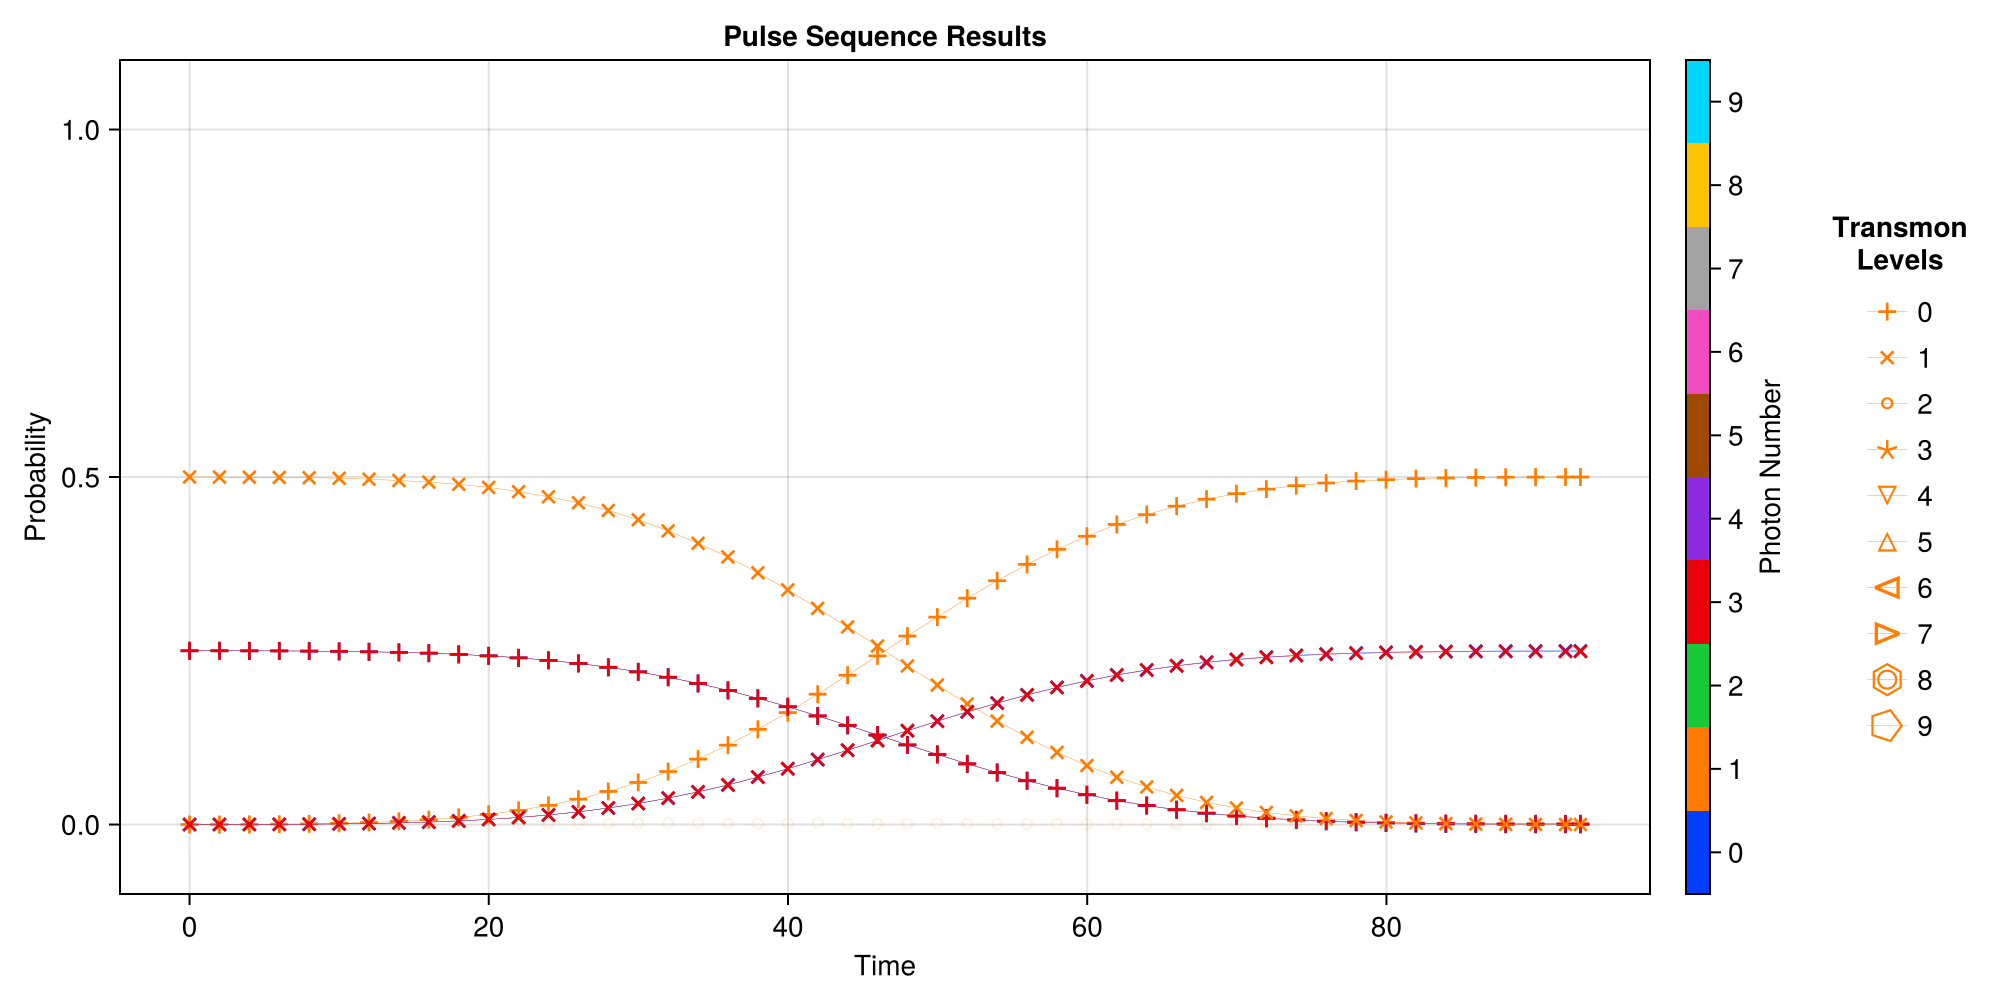

CairoMakie.Screen{IMAGE}


In [32]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ge_four_thirds_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1),(0,3),(1,3)])

In [33]:
println(EVs[(0,1)][end])
println(EVs[(1,0)][end])
println(EVs[(1,3)][end])

0.4999552881573273 + 1.539268936580038e-17im
0.24983600650336368 + 4.5186250918035015e-18im
0.24895852467398422 - 2.447701716805567e-18im


In [34]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998125245801 + 1.7447940980205284e-17im

#### $|0,2\rangle \to |1,2\rangle$

In [35]:
state1 = (0,2)
state2 = (1,2)
ψ1 = Mode2.dressed_states[state1]
ψ2 = Mode2.dressed_states[state2]

freq_d = Mode2.dressed_energies[state2]-Mode2.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge2_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 16:39:16] Info: On Level 1
[2024-11-08 16:39:16] Info: On Step 1: t = 90.0
[2024-11-08 16:39:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:39:19] Info: Time Evolution Complete
[2024-11-08 16:39:19] Info: Done with Level_1_step_1
[2024-11-08 16:39:19] Info: Accurace: 0.9971605250013522
[2024-11-08 16:39:19] Info: ------------------------------------------------------------------------------
[2024-11-08 16:39:19] Info: On Step 2: t = 92.5
[2024-11-08 16:39:19] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:39:23] Info: Time Evolution Complete
[2024-11-08 16:39:23] Info: Done with Level_1_step_2
[2024-11-08 16:39:23] Info: Accurace: 0.9996426407133202
[2024-11-08 16:39:23] Info: ------------------------------------------------------------------------------
[2024-11-08 16:39:23] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999712
  "freq_d"        => 4.60373

In [36]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ge_2"] = deepcopy(qubit_ge2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999712
  "freq_d"        => 4.60373

In [37]:
ψ = Mode2.dressed_states[(0, 2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge2_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ge_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:41:00.962
It is being saved at: Data/
[2024-11-08 16:41:00] Info: Running operator q_ge_2
[2024-11-08 16:41:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:41:04] Info: Time Evolution Complete
[2024-11-08 16:41:04] Info: Saving Steps
[2024-11-08 16:41:05] Info: Done with Step_1
[2024-11-08 16:41:05] Info: Done With Running Sequence
[2024-11-08 16:41:05] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [38]:
EVs = SC.Utils.Get_EVs(q_ge2_res["states"], proj_dict);

[2024-11-08 16:41:06] Info: Making Plot


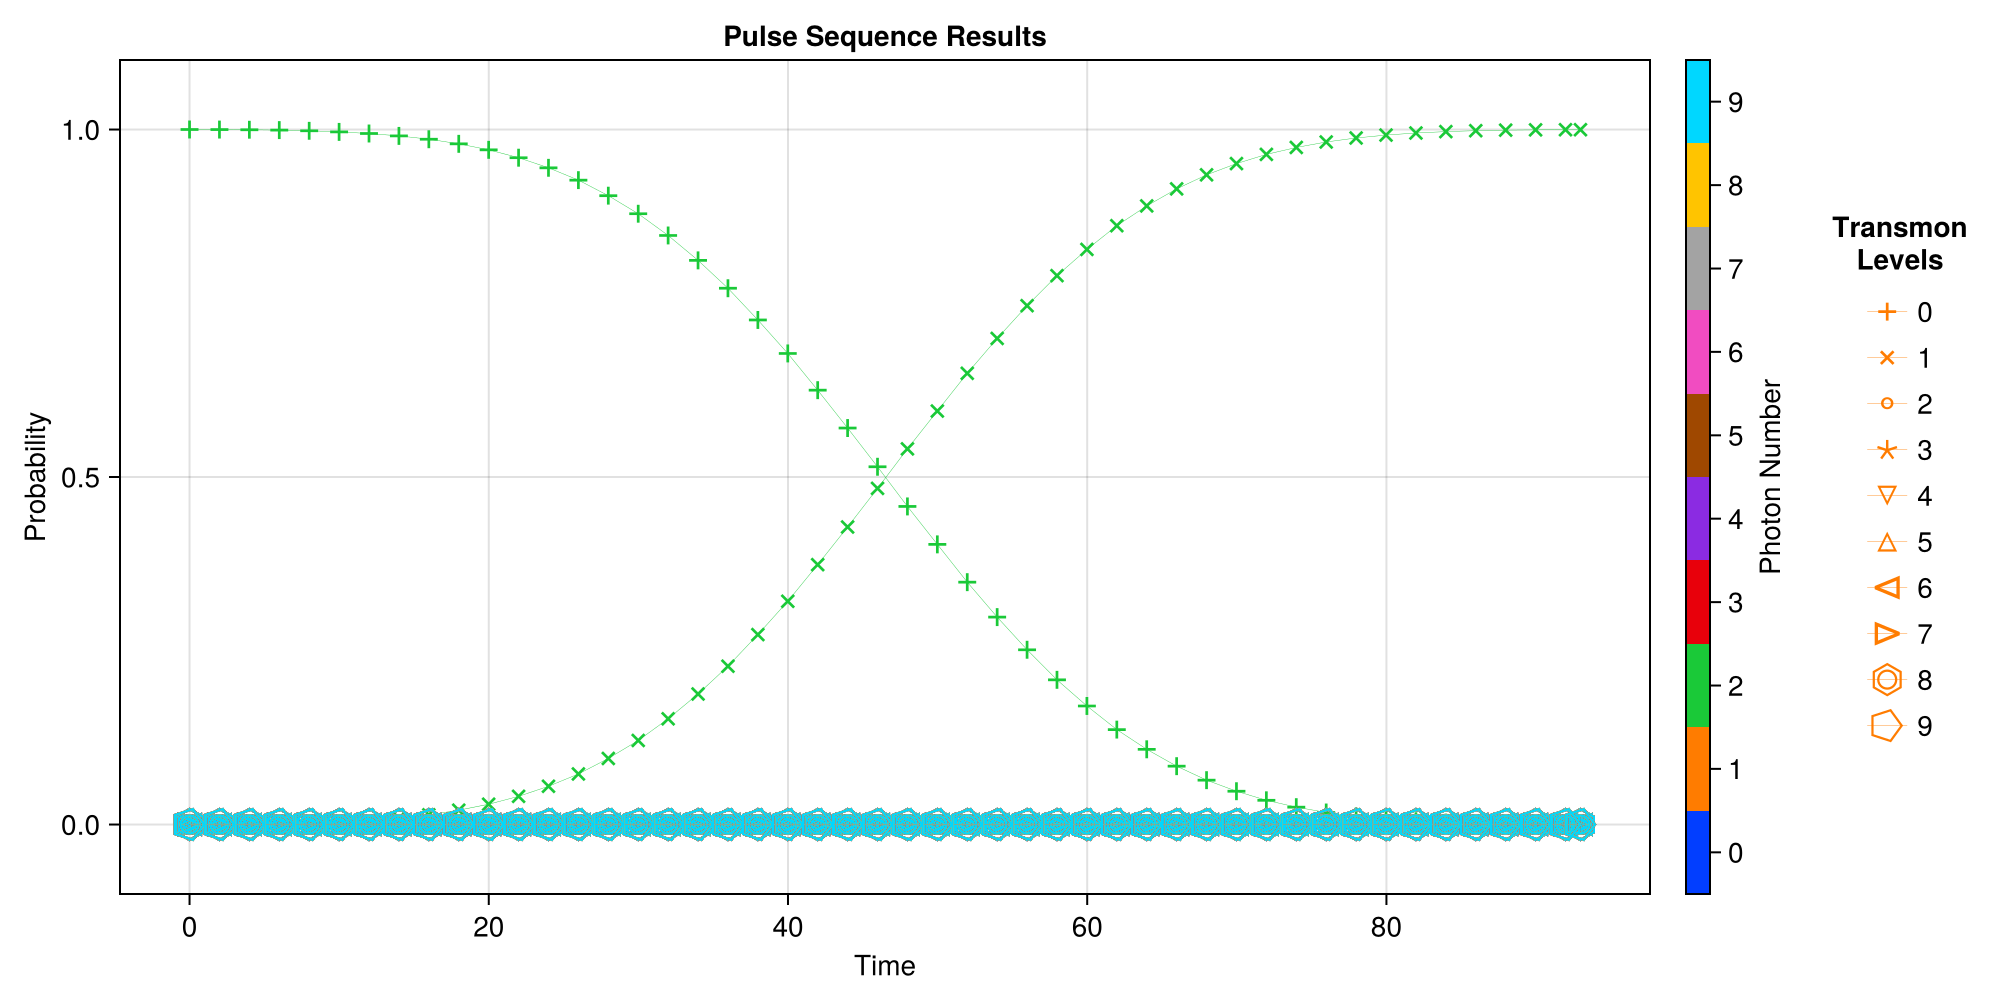

CairoMakie.Screen{IMAGE}


In [39]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ge2_res["times"], EVs, plot_every = 10)

In [40]:
EVs[(1,2)][end]

0.9997123538713905 + 1.6402673287178326e-16im

In [41]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999995223291611 + 1.6497506414890142e-16im

#### $|0,3\rangle \to |1,3\rangle$

In [42]:
state1 = (0,3)
state2 = (1,3)
ψ1 = Mode2.dressed_states[state1]
ψ2 = Mode2.dressed_states[state2]

freq_d = Mode2.dressed_energies[state2]-Mode2.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge3_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 16:41:07] Info: On Level 1
[2024-11-08 16:41:07] Info: On Step 1: t = 90.0
[2024-11-08 16:41:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:41:11] Info: Time Evolution Complete
[2024-11-08 16:41:11] Info: Done with Level_1_step_1
[2024-11-08 16:41:11] Info: Accurace: 0.9971557573862153
[2024-11-08 16:41:11] Info: ------------------------------------------------------------------------------
[2024-11-08 16:41:11] Info: On Step 2: t = 92.5
[2024-11-08 16:41:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-08 16:41:16] Info: Time Evolution Complete
[2024-11-08 16:41:16] Info: Done with Level_1_step_2
[2024-11-08 16:41:16] Info: Accurace: 0.9996423926348711
[2024-11-08 16:41:16] Info: ------------------------------------------------------------------------------
[2024-11-08 16:41:16] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60352

In [43]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ge_3"] = deepcopy(qubit_ge3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60352

In [44]:
ψ = Mode2.dressed_states[(0, 3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge3_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ge_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:42:56.197
It is being saved at: Data/
[2024-11-08 16:42:56] Info: Running operator q_ge_3
[2024-11-08 16:42:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-08 16:43:01] Info: Time Evolution Complete
[2024-11-08 16:43:01] Info: Saving Steps
[2024-11-08 16:43:02] Info: Done with Step_1
[2024-11-08 16:43:02] Info: Done With Running Sequence
[2024-11-08 16:43:02] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [45]:
EVs = SC.Utils.Get_EVs(q_ge3_res["states"], proj_dict);

[2024-11-08 16:43:02] Info: Making Plot


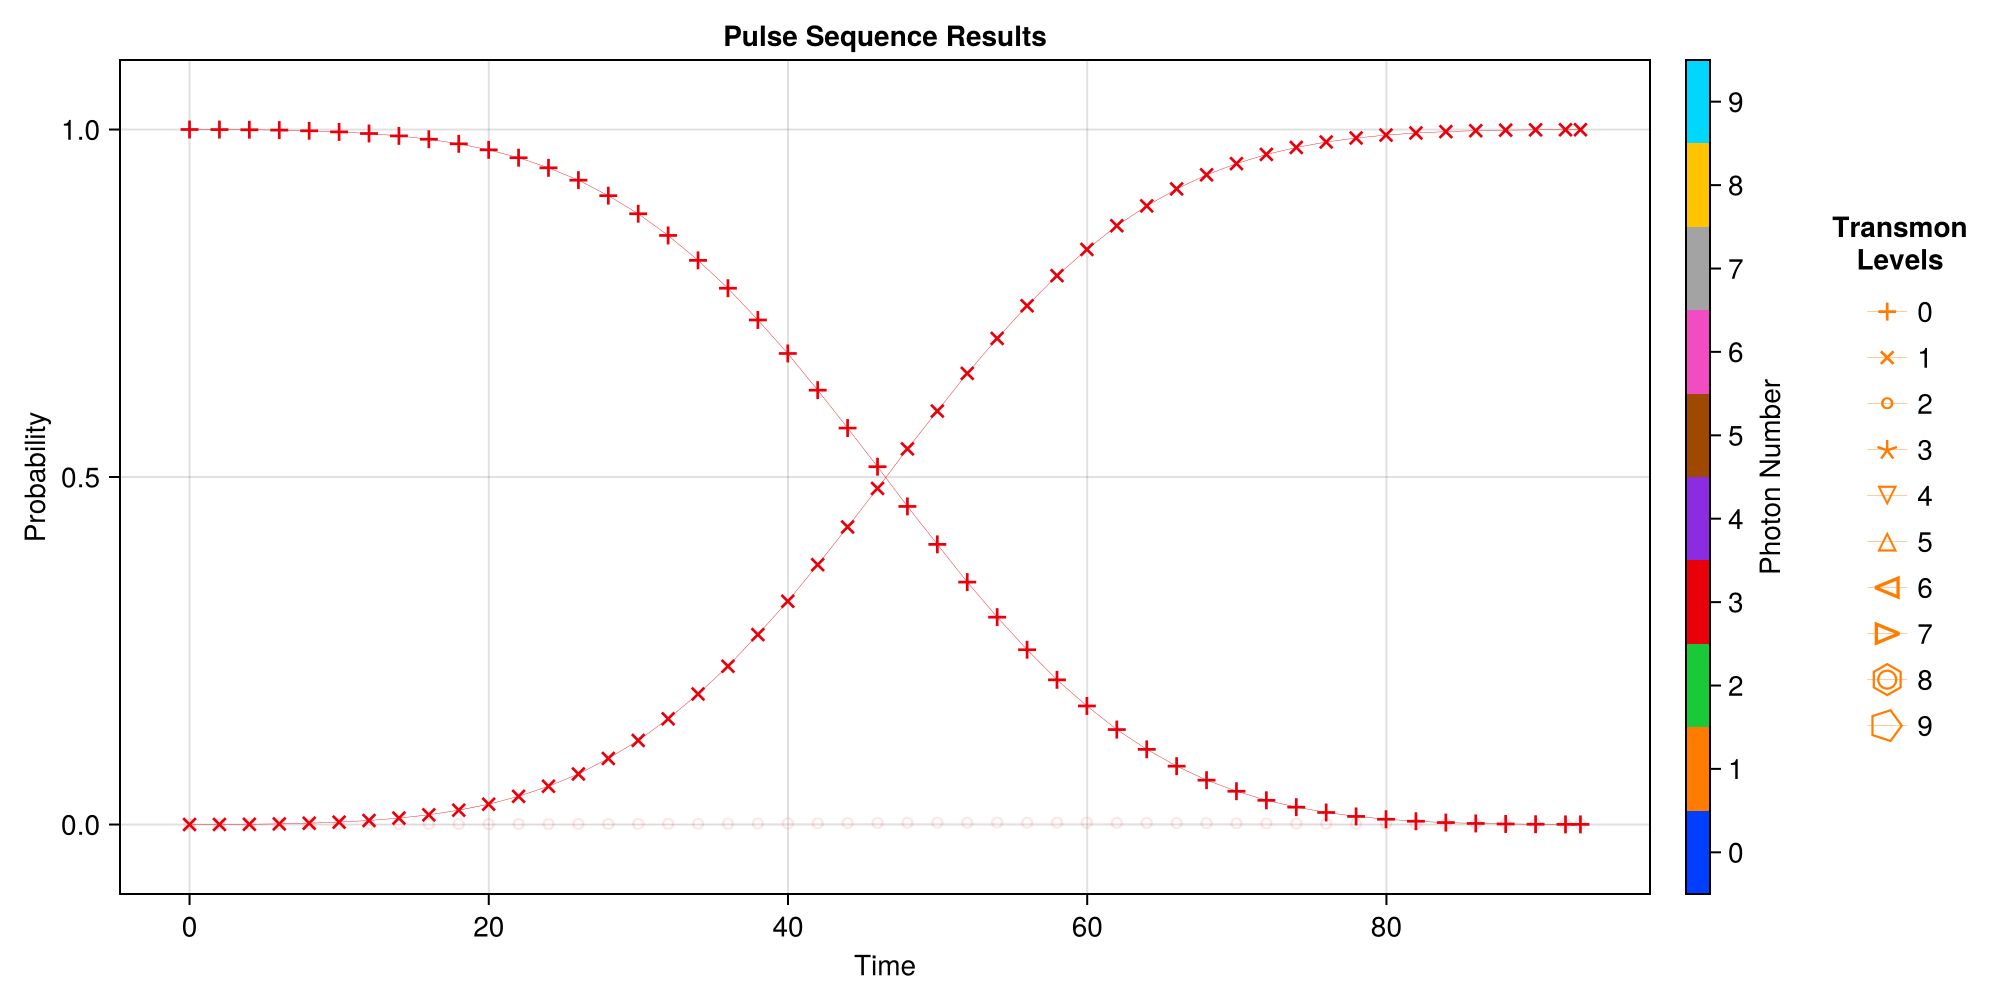

CairoMakie.Screen{IMAGE}


In [46]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ge3_res["times"], EVs, plot_every = 10, emph_states = [(0,3),(1,3)])

In [47]:
EVs[(1,3)][end]

0.9997130153358257 - 8.18106231187093e-18im

In [48]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999950612073 - 8.181751207368385e-18im

### Guassian e -> f

In [49]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


##### Getting Stark Shift

[2024-11-08 16:43:03] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


[2024-11-08 16:43:12] Info: Done With Floquet Sweep
[2024-11-08 16:43:12] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00016523815788555994	 0.008955839485366424	 2.006284954993285
Stark shift res: [0.00016523815788555994, 55.65460213761961]


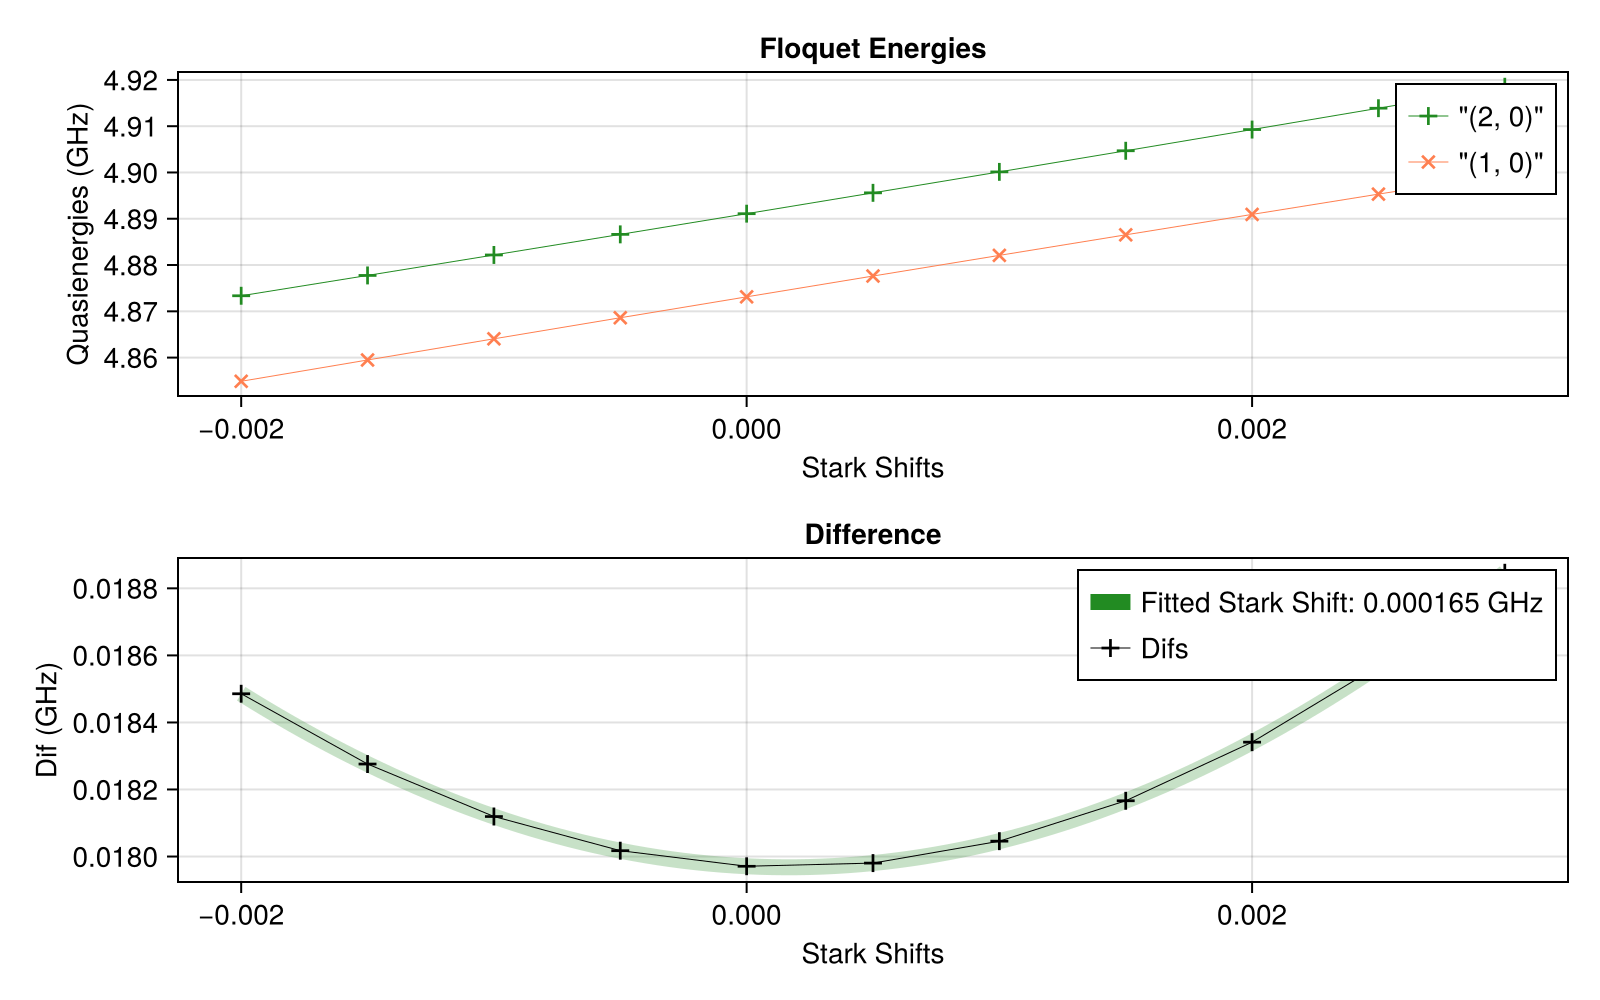

In [50]:
ef_ε = 0.00385
drive_op = Mode2.n̂ₜ
state1 = (1,0)
state2 = (2,0)

stark_shift_list = collect(LinRange(-0.002, 0.003, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode2, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))

ef_stark_shift = stark_shift_res[1];

##### $|1,0\rangle \to |2,0\rangle$

In [51]:
state1 = (1,0)
state2 = (2,0)
ψ1 = Mode2.dressed_states[state1]
ψ2 = Mode2.dressed_states[state2]

freq_d = Mode2.dressed_energies[state2]-Mode2.dressed_energies[state1] + ef_stark_shift


envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef0_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 16:43:12] Info: On Level 1
[2024-11-08 16:43:12] Info: On Step 1: t = 90.0
[2024-11-08 16:43:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:43:16] Info: Time Evolution Complete
[2024-11-08 16:43:16] Info: Done with Level_1_step_1
[2024-11-08 16:43:16] Info: Accurace: 0.9972479716688496
[2024-11-08 16:43:16] Info: ------------------------------------------------------------------------------
[2024-11-08 16:43:16] Info: On Step 2: t = 92.5
[2024-11-08 16:43:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:43:21] Info: Time Evolution Complete
[2024-11-08 16:43:21] Info: Done with Level_1_step_2
[2024-11-08 16:43:21] Info: Accurace: 0.9997292286695996
[2024-11-08 16:43:21] Info: ------------------------------------------------------------------------------
[2024-11-08 16:43:21] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999795
  "freq_d"        => 4.49573

In [52]:
#Mode2.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999795
  "freq_d"        => 4.49573

In [53]:
ψ = Mode2.dressed_states[(1,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef0_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ef_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:44:49.424
It is being saved at: Data/
[2024-11-08 16:44:49] Info: Running operator q_ef_0
[2024-11-08 16:44:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-08 16:44:54] Info: Time Evolution Complete
[2024-11-08 16:44:54] Info: Saving Steps
[2024-11-08 16:44:55] Info: Done with Step_1
[2024-11-08 16:44:55] Info: Done With Running Sequence
[2024-11-08 16:44:55] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [54]:
EVs_ef0 = SC.Utils.Get_EVs(q_ef0_res["states"], proj_dict);

[2024-11-08 16:44:55] Info: Making Plot


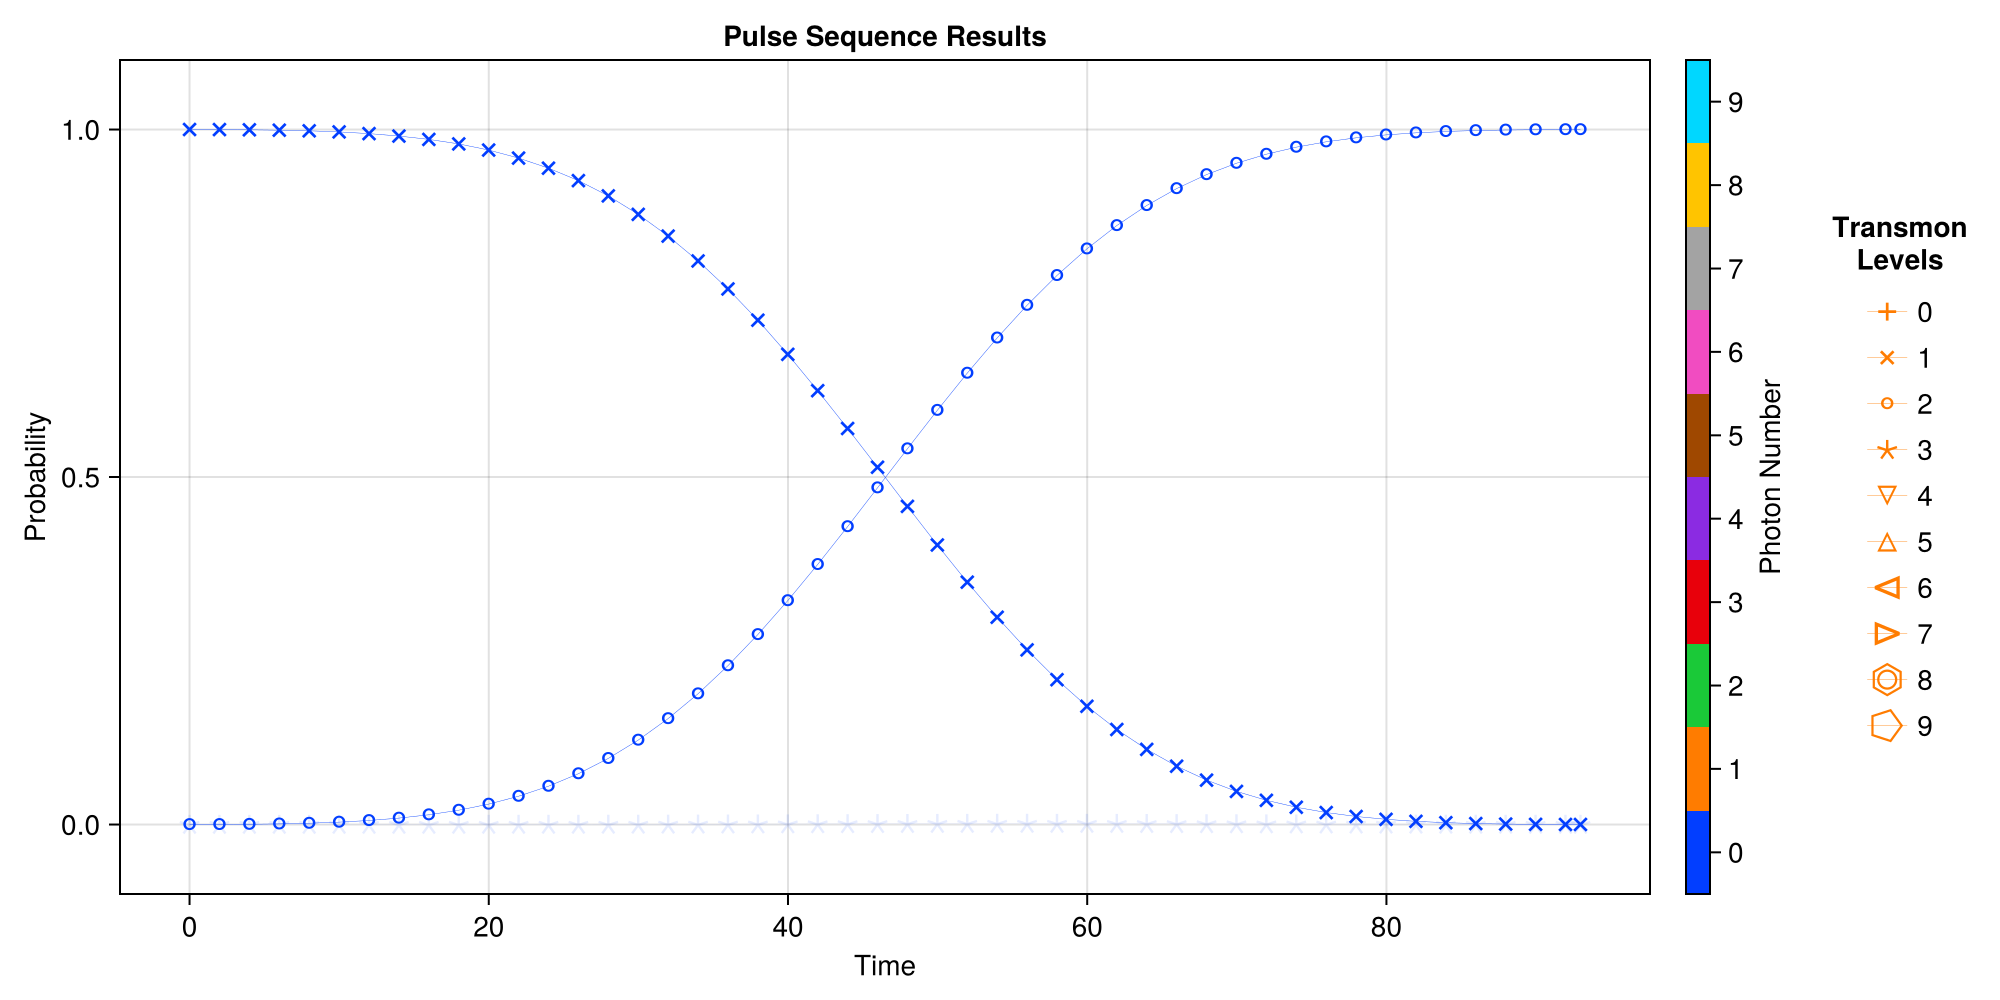

CairoMakie.Screen{IMAGE}


In [55]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ef0_res["times"], EVs_ef0, plot_every = 10, emph_states = [(1,0),(2,0)])

In [56]:
println(EVs_ef0[(0,0)][end])
println(EVs_ef0[(1,0)][end])
println(EVs_ef0[(2,0)][end])
println(EVs_ef0[(3,0)][end])

1.5785277636437273e-5 - 1.3014296523779205e-21im
4.68343486796578e-5 - 4.027641094912984e-21im
0.9998916498289586 + 8.067407727970965e-18im
4.302331536307464e-5 + 3.457916952280383e-21im


In [57]:
tot = 0
for key in keys(EVs_ef0)
    tot+=EVs_ef0[key][end]
end
print(tot)

0.999997293090569 + 7.886133276669113e-18im

##### $|1,1\rangle \to |2,1\rangle$

In [58]:
state1 = (1,1)
state2 = (2,1)
ψ1 = Mode2.dressed_states[state1]
ψ2 = Mode2.dressed_states[state2]

freq_d = Mode2.dressed_energies[state2]-Mode2.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef1_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 16:44:56] Info: On Level 1
[2024-11-08 16:44:56] Info: On Step 1: t = 90.0
[2024-11-08 16:44:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:45:00] Info: Time Evolution Complete
[2024-11-08 16:45:00] Info: Done with Level_1_step_1
[2024-11-08 16:45:00] Info: Accurace: 0.997340534538609
[2024-11-08 16:45:00] Info: ------------------------------------------------------------------------------
[2024-11-08 16:45:00] Info: On Step 2: t = 92.5
[2024-11-08 16:45:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:45:03] Info: Time Evolution Complete
[2024-11-08 16:45:03] Info: Done with Level_1_step_2
[2024-11-08 16:45:03] Info: Accurace: 0.999826342376711
[2024-11-08 16:45:03] Info: ------------------------------------------------------------------------------
[2024-11-08 16:45:03] Info: On St

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999893
  "freq_d"        => 4.49555

In [59]:
#Mode2.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999893
  "freq_d"        => 4.49555

In [60]:
ψ = Mode2.dressed_states[(1,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef1_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ef_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:46:41.589
It is being saved at: Data/
[2024-11-08 16:46:41] Info: Running operator q_ef_1
[2024-11-08 16:46:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:46:45] Info: Time Evolution Complete
[2024-11-08 16:46:45] Info: Saving Steps
[2024-11-08 16:46:45] Info: Done with Step_1
[2024-11-08 16:46:45] Info: Done With Running Sequence
[2024-11-08 16:46:45] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [61]:
EVs = SC.Utils.Get_EVs(q_ef1_res["states"], proj_dict);

[2024-11-08 16:46:46] Info: Making Plot


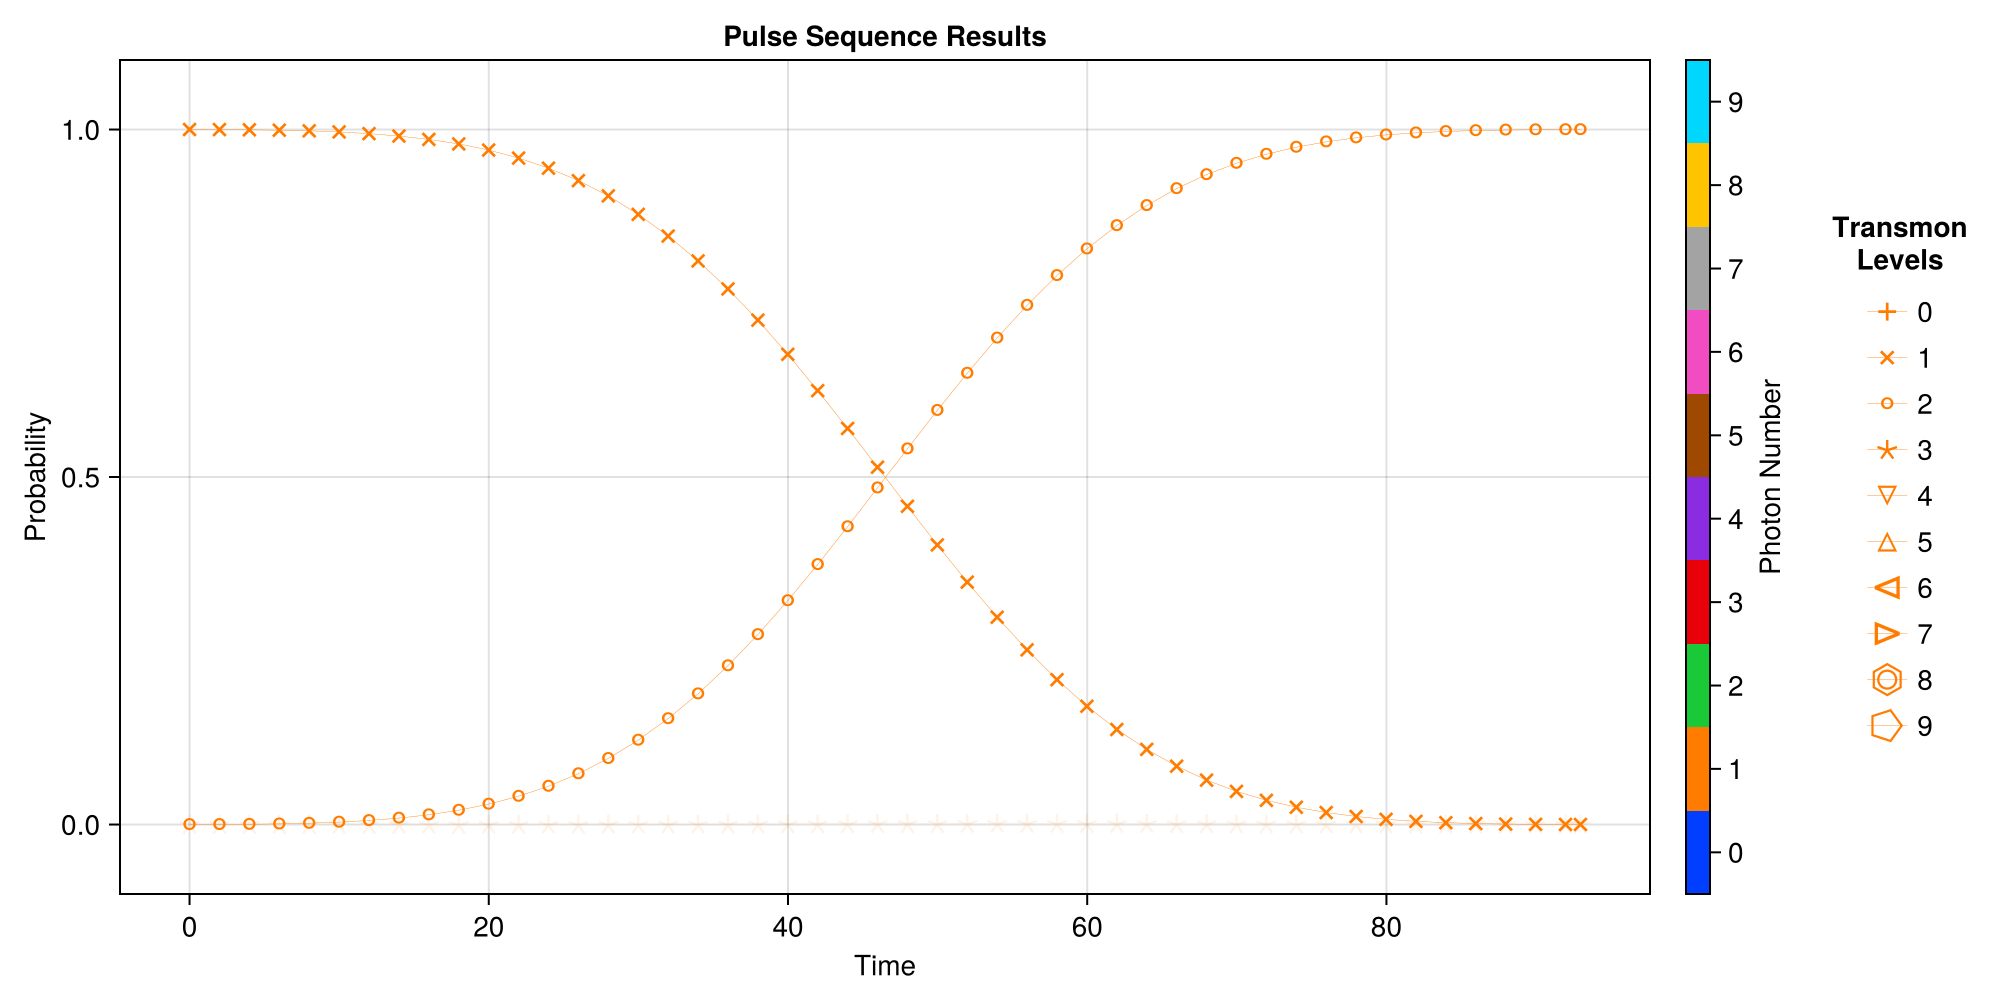

CairoMakie.Screen{IMAGE}


In [62]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ef1_res["times"], EVs, plot_every = 10, emph_states = [(1,1),(2,1)])

In [63]:
EVs[(2,1)][end]

0.9998931087606266 + 1.758190812176962e-17im

In [64]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999987335788636 + 1.744582786164792e-17im

##### $|1,0\rangle+\frac{1}{\sqrt{2}}\left(|2,0\rangle + |1, 3\rangle\right)\to |2,0\rangle+\frac{1}{\sqrt{2}}\left(|1,0\rangle + |2, 3\rangle\right)$

In [65]:
ψ1 = Mode2.dressed_states[(1,0)]/sqrt(2)+Mode2.dressed_states[(2,0)]+Mode2.dressed_states[(1,3)]/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode2.dressed_states[(2,0)]+(Mode2.dressed_states[(1,0)]+Mode2.dressed_states[(2,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_ef0 = Mode2.dressed_energies[(2,0)]-Mode2.dressed_energies[(1,0)]+ef_stark_shift
freq_d_ef1 = Mode2.dressed_energies[(2,1)]-Mode2.dressed_energies[(1,1)]+ef_stark_shift
freq_d_ef3 = Mode2.dressed_energies[(2,3)]-Mode2.dressed_energies[(1,3)]+ef_stark_shift

χ = freq_d_ef1-freq_d_ef0

freq_d = freq_d_ef0+3*χ/2

check_op = proj_dict[(2,0)]+proj_dict[(1,0)]+proj_dict[(2,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ef_three_halves_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)

[2024-11-08 16:46:46] Info: On Level 1
[2024-11-08 16:46:46] Info: On Step 1: t = 90.0
[2024-11-08 16:46:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:46:51] Info: Time Evolution Complete
[2024-11-08 16:46:51] Info: Done with Level_1_step_1
[2024-11-08 16:46:51] Info: Using Check Op
[2024-11-08 16:46:51] Info: Accurace: 0.9987809181050431
[2024-11-08 16:46:51] Info: ------------------------------------------------------------------------------
[2024-11-08 16:46:51] Info: On Step 2: t = 92.5
[2024-11-08 16:46:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:46:55] Info: Time Evolution Complete
[2024-11-08 16:46:55] Info: Done with Level_1_step_2
[2024-11-08 16:46:55] Info: Using Check Op
[2024-11-08 16:46:55] Info: Accurace: 0.9994306207345959
[2024-11-08 16:46:55] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99945
  "freq_d"        => 4.49546

In [66]:
#Mode2.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99945
  "freq_d"        => 4.49546

In [67]:
ψ = Mode2.dressed_states[(1,0)]/sqrt(2)+Mode2.dressed_states[(2,0)]+Mode2.dressed_states[(1,3)]/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ef_three_halves_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ef_3/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:48:31.856
It is being saved at: Data/
[2024-11-08 16:48:31] Info: Running operator q_ef_3/2
[2024-11-08 16:48:31] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 07s (ETA: 0h 00m 00s)
[2024-11-08 16:48:39] Info: Time Evolution Complete
[2024-11-08 16:48:39] Info: Saving Steps
[2024-11-08 16:48:40] Info: Done with Step_1
[2024-11-08 16:48:40] Info: Done With Running Sequence
[2024-11-08 16:48:40] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [68]:
EVs = SC.Utils.Get_EVs(q_ef_three_halves_res["states"], proj_dict);

[2024-11-08 16:48:40] Info: Making Plot


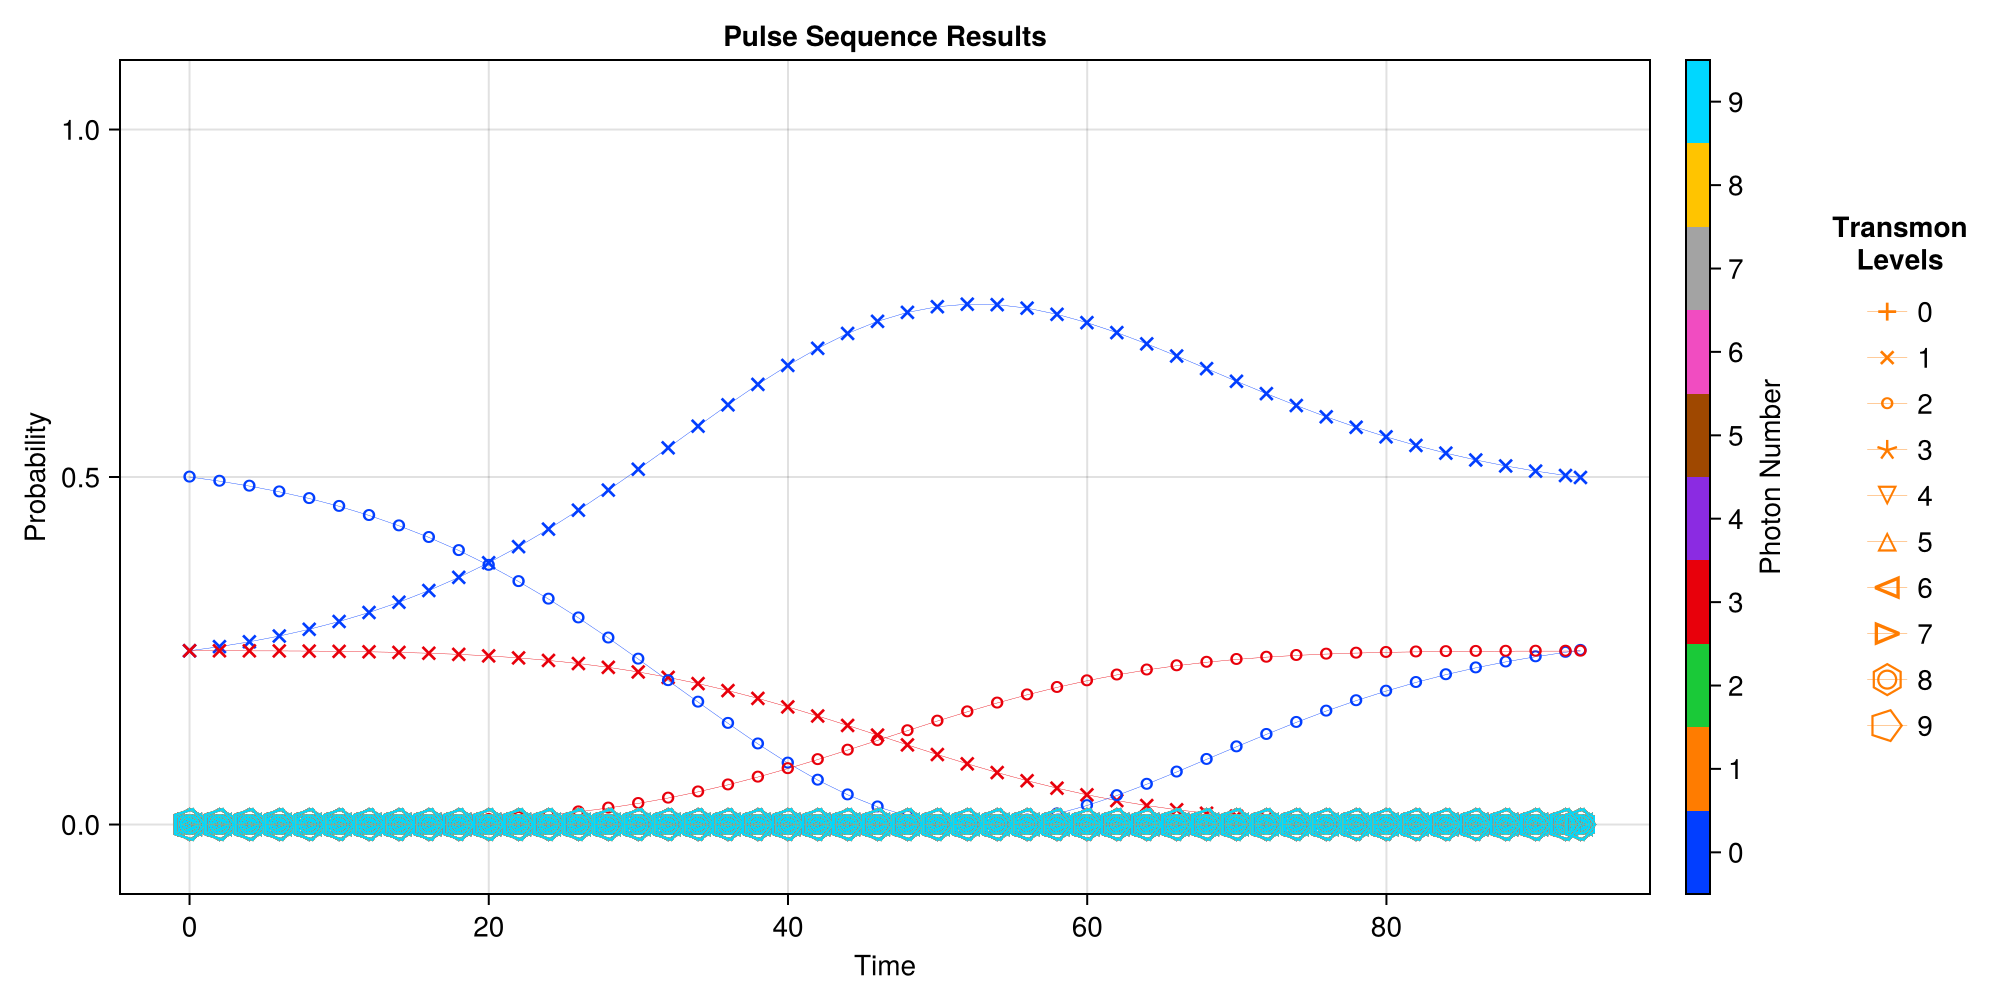

CairoMakie.Screen{IMAGE}


In [69]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ef_three_halves_res["times"], EVs, plot_every = 10)

In [70]:
println(EVs[(2,0)][end])
println(EVs[(1,0)][end])
println(EVs[(2,3)][end])

0.2506630403119394 - 6.199459833196104e-17im
0.4993297904257188 - 1.2747898816605273e-17im
0.2494979690899253 + 9.695986826351984e-18im


In [71]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997224622019 - 6.56548454410502e-17im

##### $|1,2\rangle \to |2,2\rangle$

In [72]:
state1 = (1,2)
state2 = (2,2)
ψ1 = Mode2.dressed_states[state1]
ψ2 = Mode2.dressed_states[state2]

freq_d = Mode2.dressed_energies[state2]-Mode2.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef2_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 7)


[2024-11-08 16:48:41] Info: On Level 1
[2024-11-08 16:48:41] Info: On Step 1: t = 90.0
[2024-11-08 16:48:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:48:46] Info: Time Evolution Complete
[2024-11-08 16:48:46] Info: Done with Level_1_step_1
[2024-11-08 16:48:46] Info: Accurace: 0.9973377760547939
[2024-11-08 16:48:46] Info: ------------------------------------------------------------------------------
[2024-11-08 16:48:46] Info: On Step 2: t = 92.5
[2024-11-08 16:48:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 16:48:50] Info: Time Evolution Complete
[2024-11-08 16:48:50] Info: Done with Level_1_step_2
[2024-11-08 16:48:50] Info: Accurace: 0.9998266943985948
[2024-11-08 16:48:50] Info: ------------------------------------------------------------------------------
[2024-11-08 16:48:50] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49537

In [73]:
#Mode2.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49537

In [74]:
ψ = Mode2.dressed_states[(1,2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef2_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ef_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:50:17.637
It is being saved at: Data/
[2024-11-08 16:50:17] Info: Running operator q_ef_2
[2024-11-08 16:50:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 16:50:19] Info: Time Evolution Complete
[2024-11-08 16:50:19] Info: Saving Steps
[2024-11-08 16:50:19] Info: Done with Step_1
[2024-11-08 16:50:19] Info: Done With Running Sequence
[2024-11-08 16:50:19] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [75]:
EVs = SC.Utils.Get_EVs(q_ef2_res["states"], proj_dict);

[2024-11-08 16:50:20] Info: Making Plot


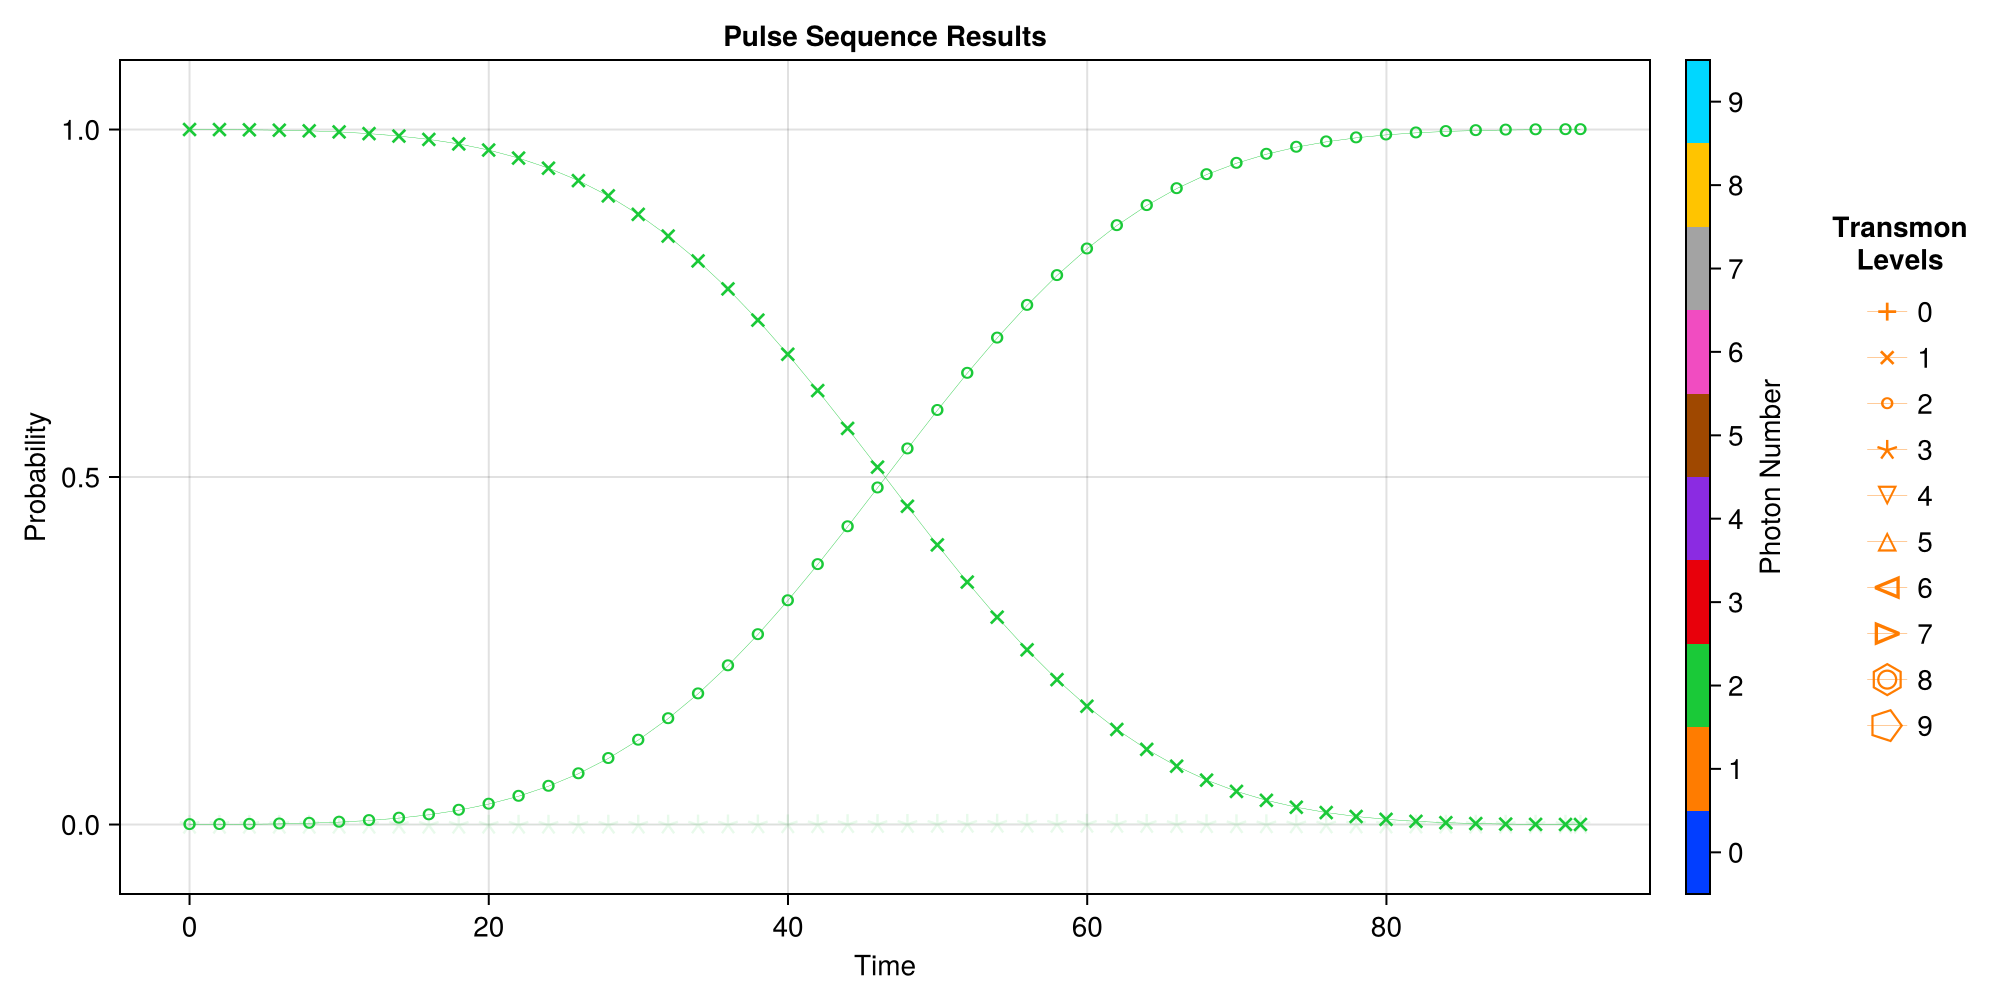

CairoMakie.Screen{IMAGE}


In [76]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ef2_res["times"], EVs, plot_every = 10, emph_states = [(1,2),(2,2)])

In [77]:
EVs[(2,2)][end]

0.9998943838004212 - 5.745247948971122e-17im

In [78]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999919092788 - 5.761106439254926e-17im

##### $|1,3\rangle \to |2,3\rangle$

In [79]:
state1 = (1,3)
state2 = (2,3)
ψ1 = Mode2.dressed_states[state1]
ψ2 = Mode2.dressed_states[state2]

freq_d = Mode2.dressed_energies[state2]-Mode2.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 110]

qubit_ef3_opt_res = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 16:50:20] Info: On Level 1
[2024-11-08 16:50:20] Info: On Step 1: t = 90.0
[2024-11-08 16:50:20] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 16:50:21] Info: Time Evolution Complete
[2024-11-08 16:50:21] Info: Done with Level_1_step_1
[2024-11-08 16:50:21] Info: Accurace: 0.997334132936962
[2024-11-08 16:50:21] Info: ------------------------------------------------------------------------------
[2024-11-08 16:50:21] Info: On Step 2: t = 95.0
[2024-11-08 16:50:21] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 16:50:23] Info: Time Evolution Complete
[2024-11-08 16:50:23] Info: Done with Level_1_step_2
[2024-11-08 16:50:23] Info: Accurace: 0.9987486073554207
[2024-11-08 16:50:23] Info: ------------------------------------------------------------------------------
[2024-11-08 16:50:23] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99989
  "freq_d"        => 4.49519

In [80]:
#Mode2.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99989
  "freq_d"        => 4.49519

In [81]:
ψ = Mode2.dressed_states[(1,3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef3_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_ef_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T16:51:32.574
It is being saved at: Data/
[2024-11-08 16:51:32] Info: Running operator q_ef_3
[2024-11-08 16:51:32] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:51:36] Info: Time Evolution Complete
[2024-11-08 16:51:36] Info: Saving Steps
[2024-11-08 16:51:37] Info: Done with Step_1
[2024-11-08 16:51:37] Info: Done With Running Sequence
[2024-11-08 16:51:37] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [82]:
EVs = SC.Utils.Get_EVs(q_ef3_res["states"], proj_dict);

[2024-11-08 16:51:37] Info: Making Plot


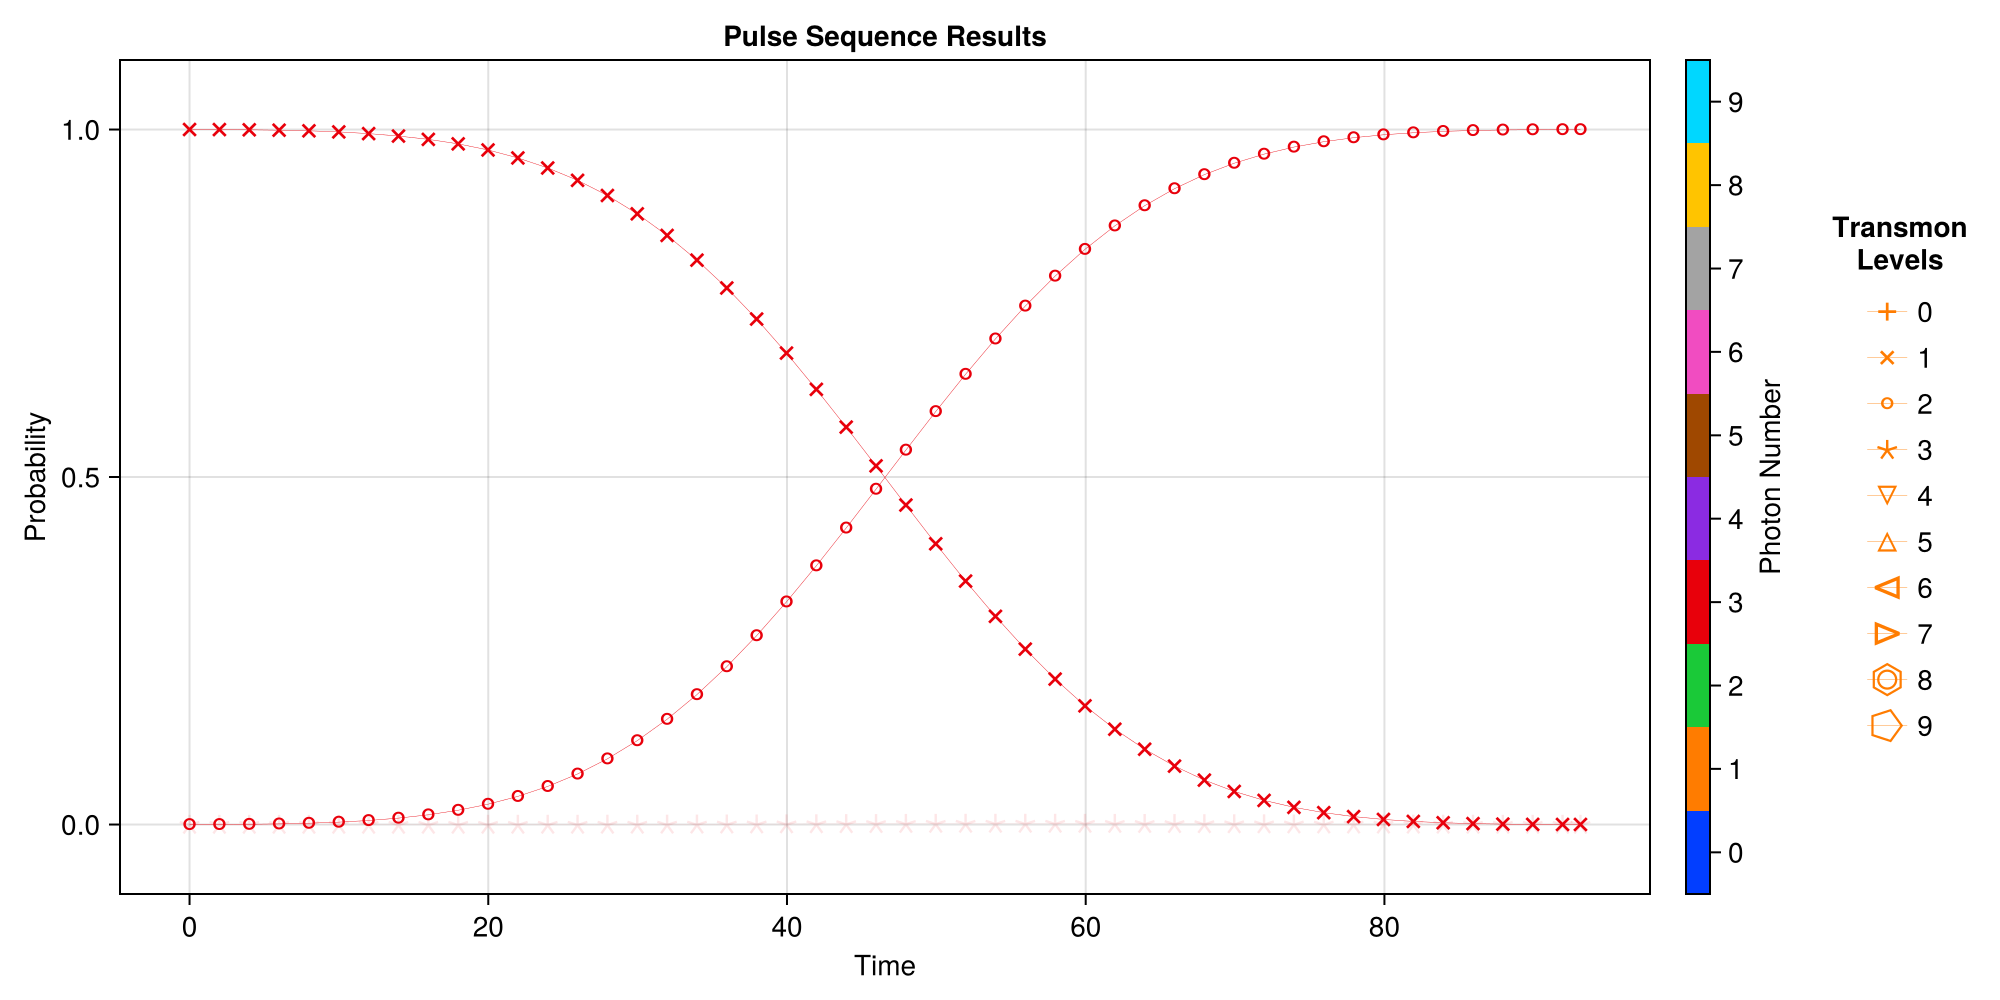

CairoMakie.Screen{IMAGE}


In [83]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, q_ef3_res["times"], EVs, plot_every = 10, emph_states = [(1,3),(2,3)])

In [84]:
EVs[(2, 3)][end]

0.9998897346579839 + 6.137604332198853e-18im

In [85]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
tot

0.9999999999951551 + 6.044743655320039e-18im

### Half Qubit $|g0\rangle \to |g0\rangle+|e0\rangle$

In [86]:
starting_args = deepcopy(Mode2.Stuff["op_drive_params"]["q_ge_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode2.dressed_states[(0,0)]
ψ2 = Mode2.dressed_states[(0,0)] + Mode2.dressed_states[(1,0)]
ψ2 = ψ2/sqrt(2)

op = Mode2.dressed_states[(0,0)]*Mode2.dressed_states[(1,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_g0e0 = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-11-08 16:51:38] Info: On Level 1
[2024-11-08 16:51:38] Info: On Step 1: t = 92.96875
[2024-11-08 16:51:38] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:51:42] Info: Time Evolution Complete
[2024-11-08 16:51:42] Info: Done with Level_1_step_1
[2024-11-08 16:51:42] Info: Using Check Op
[2024-11-08 16:51:42] Info: Accurace: 0.9995592887854023
[2024-11-08 16:51:42] Info: ------------------------------------------------------------------------------
[2024-11-08 16:51:42] Info: Highest Accuracy: 0.9995592887854023
[2024-11-08 16:51:42] Info: New ti: 92.96875, new tf: 92.96875
[2024-11-08 16:51:42] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999559
  "freq_d"        => 4.60416

In [87]:
#Mode2.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999559
  "freq_d"        => 4.60416

In [88]:
ψ = Mode2.dressed_states[(0,0)]
res_half_ge0 = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["q_half_ge0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T16:51:42.462
It is being saved at: Data/
[2024-11-08 16:51:42] Info: Running operator q_half_ge0
[2024-11-08 16:51:42] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 16:51:46] Info: Time Evolution Complete
[2024-11-08 16:51:46] Info: Saving Steps
[2024-11-08 16:51:47] Info: Done with Step_1
[2024-11-08 16:51:47] Info: Done With Running Sequence
[2024-11-08 16:51:47] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [89]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ge0["states"], proj_dict);

[2024-11-08 16:51:47] Info: Making Plot


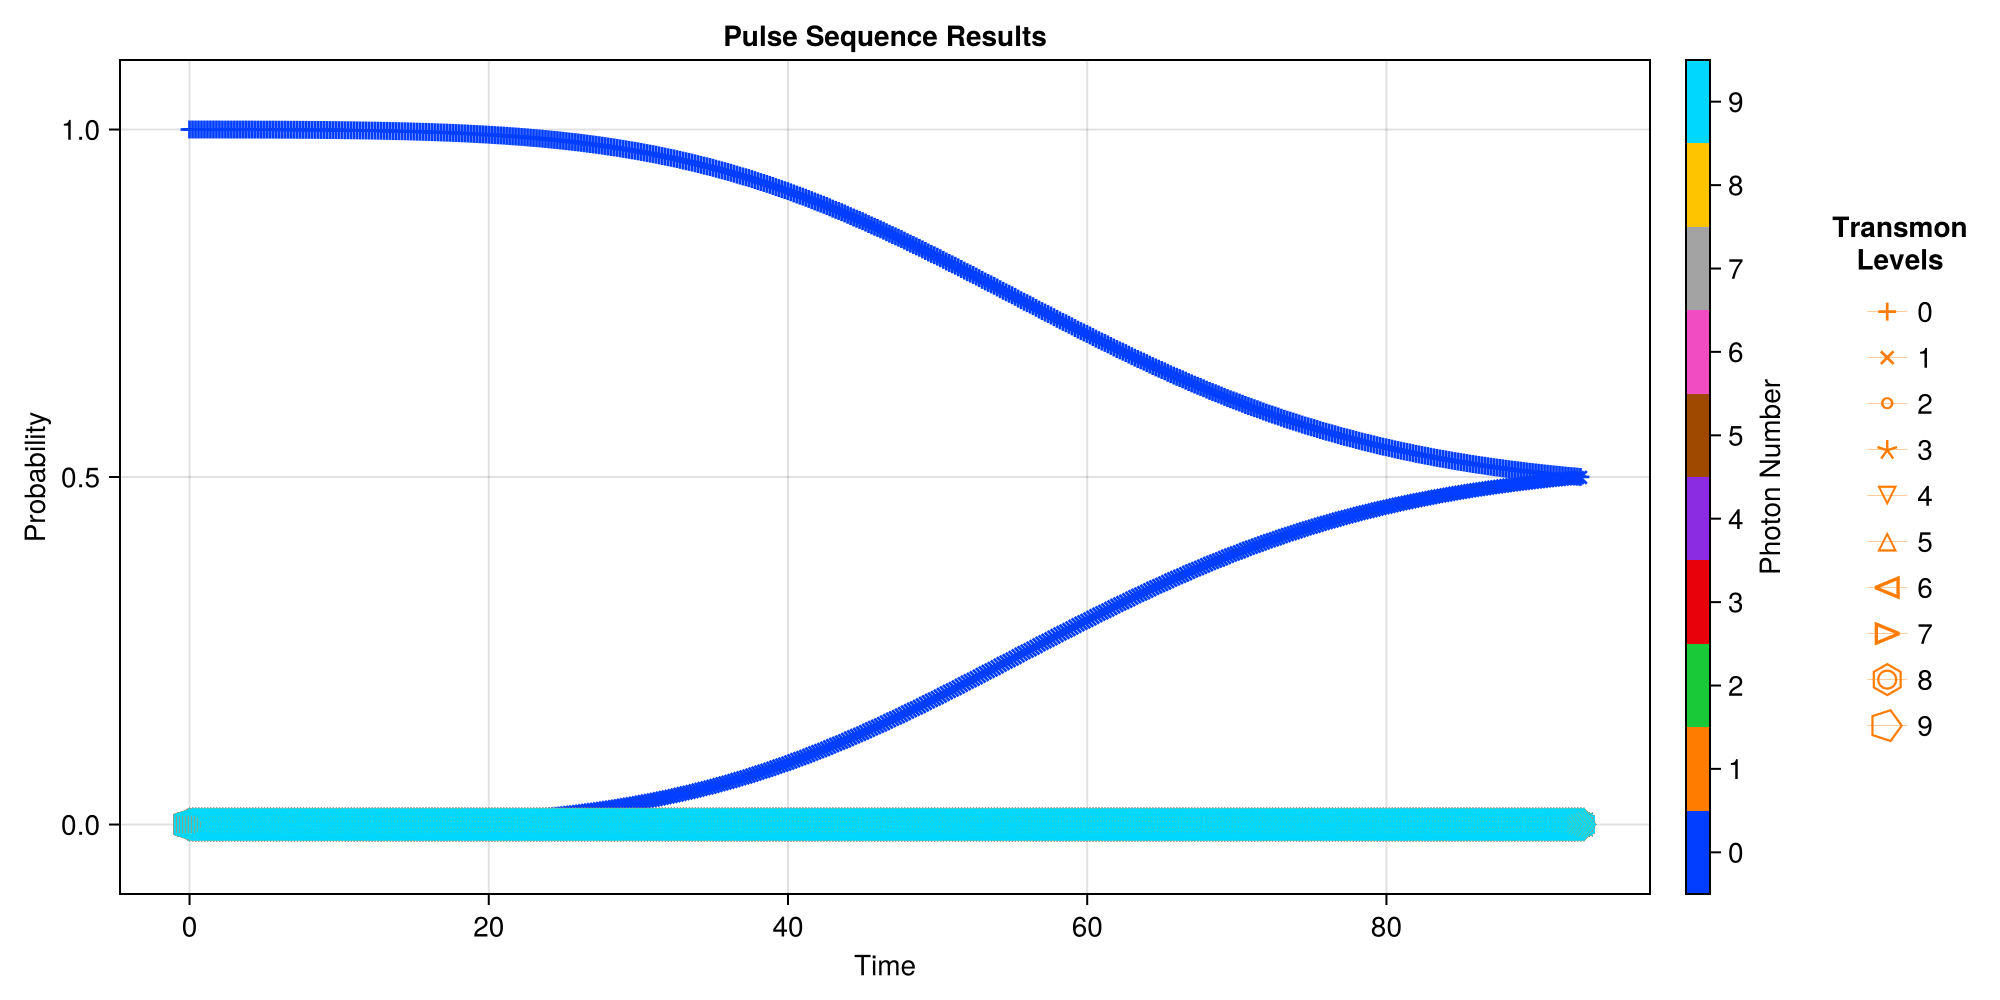

In [90]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, res_half_ge0["times"], EVs_Dict);

In [91]:
println(EVs_Dict[(0,0)][end])
println(EVs_Dict[(1,0)][end])

0.5001129658544016 + 5.1535672970583526e-17im
0.49944654508720193 + 2.070942164465878e-18im


## Sidebands at $\varepsilon = 0.595$

### Getting Stark Shift

[2024-11-08 18:19:39] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


[2024-11-08 18:19:47] Info: Done With Floquet Sweep
[2024-11-08 18:19:47] Info: Fit Stuff: 3-element Vector{Float64}:	 0.037204608786014504	 0.002416769115757027	 2.1406303982895607
Stark shift res: [0.037204608786014504, 193.29612562001518]


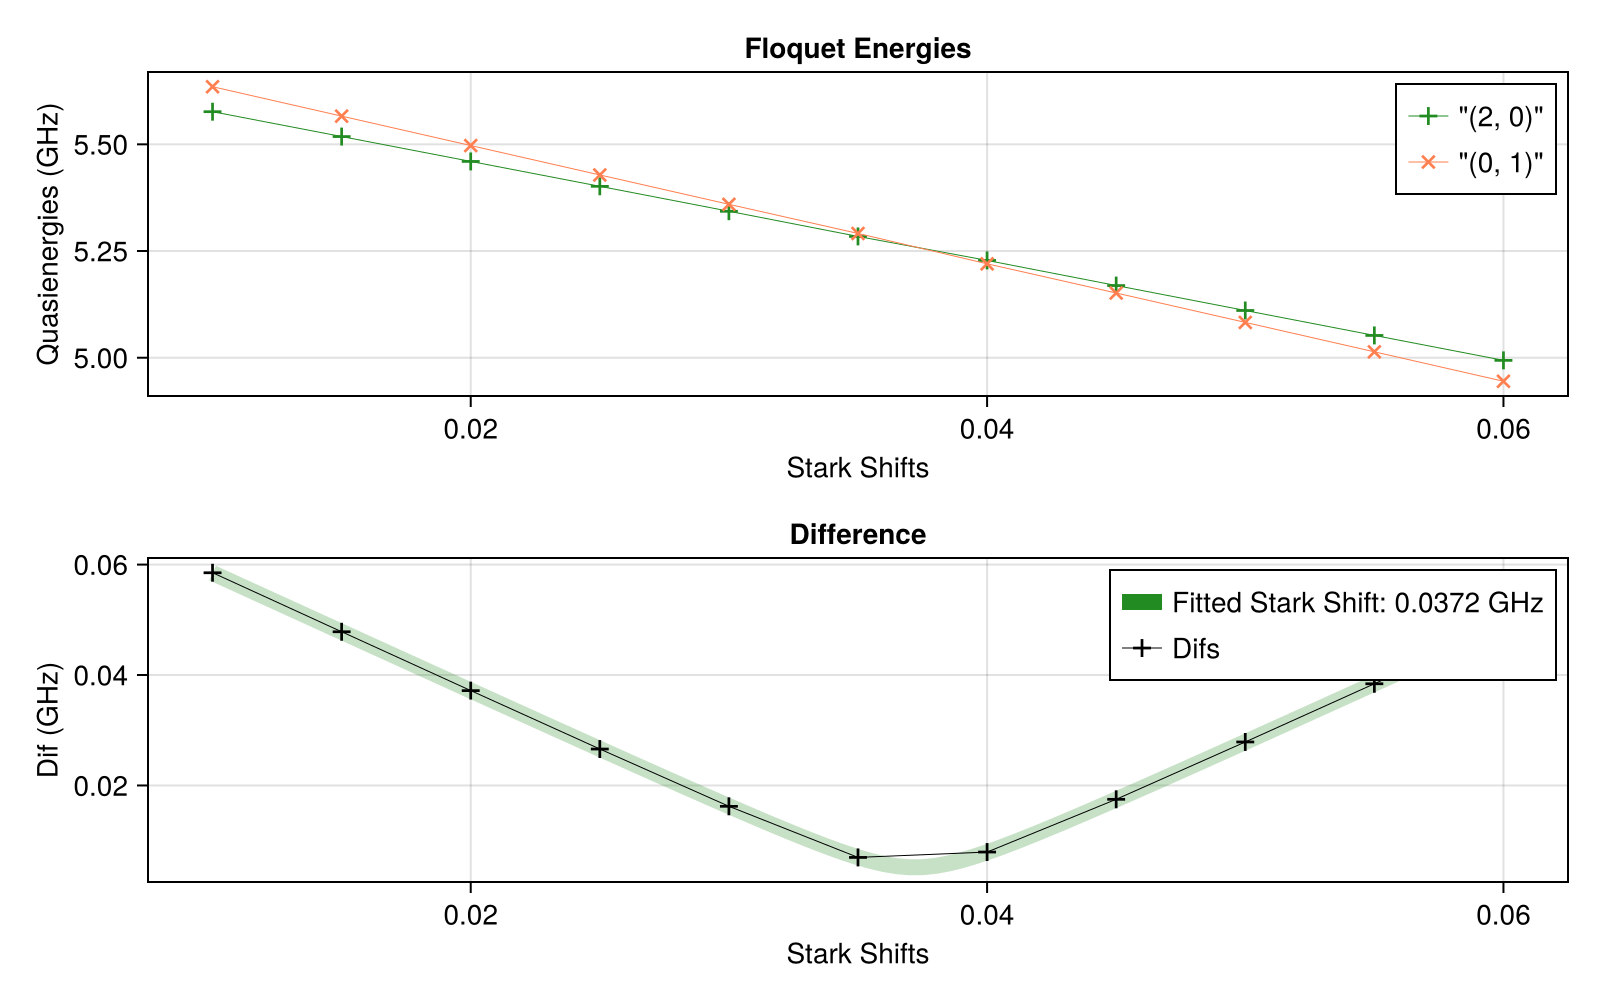

In [115]:
fngnp1_ε = 0.595
drive_op = Mode2.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.01, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode2, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [116]:
fngnp1_ramp_time = 11.6257;

### f0->g1


In [117]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][2][1]*1000))

Target flattop time: 181.36160714285714


In [118]:
ψ1 = Mode2.dressed_states[(2,0)]
ψ2 = Mode2.dressed_states[(0,1)]

freq_d = Mode2.dressed_energies[(0,1)]-Mode2.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 18:19:47] Info: On Level 1
[2024-11-08 18:19:47] Info: On Step 1: t = 193.29612562001518
[2024-11-08 18:19:47] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 18:19:50] Info: Time Evolution Complete
[2024-11-08 18:19:50] Info: Done with Level_1_step_1
[2024-11-08 18:19:50] Info: Accurace: 0.9903980239945886
[2024-11-08 18:19:50] Info: ------------------------------------------------------------------------------
[2024-11-08 18:19:50] Info: On Step 2: t = 199.1089756200152
[2024-11-08 18:19:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 18:19:54] Info: Time Evolution Complete
[2024-11-08 18:19:54] Info: Done with Level_1_step_2
[2024-11-08 18:19:54] Info: Accurace: 0.9971336838411143
[2024-11-08 18:19:54] Info: ------------------------------------------------------------------------------
[202

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 204.922
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>204.922, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999411
  "freq_d"        => -3.10422

In [119]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

181.67042562001518

In [120]:
#Mode2.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 204.922
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>204.922, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999411
  "freq_d"        => -3.10422

In [121]:
ψ = Mode2.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T18:24:08.561
It is being saved at: Data/
[2024-11-08 18:24:08] Info: Running operator sb_f0g1
[2024-11-08 18:24:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 16s (ETA: 0h 00m 00s)
[2024-11-08 18:24:24] Info: Time Evolution Complete
[2024-11-08 18:24:24] Info: Saving Steps
[2024-11-08 18:24:25] Info: Done with Step_1
[2024-11-08 18:24:25] Info: Done With Running Sequence
[2024-11-08 18:24:25] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199924, 0.399847, 0.599771, 0.799695, 0.999619, 1.1995…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [122]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

[2024-11-08 18:24:26] Info: Making Plot


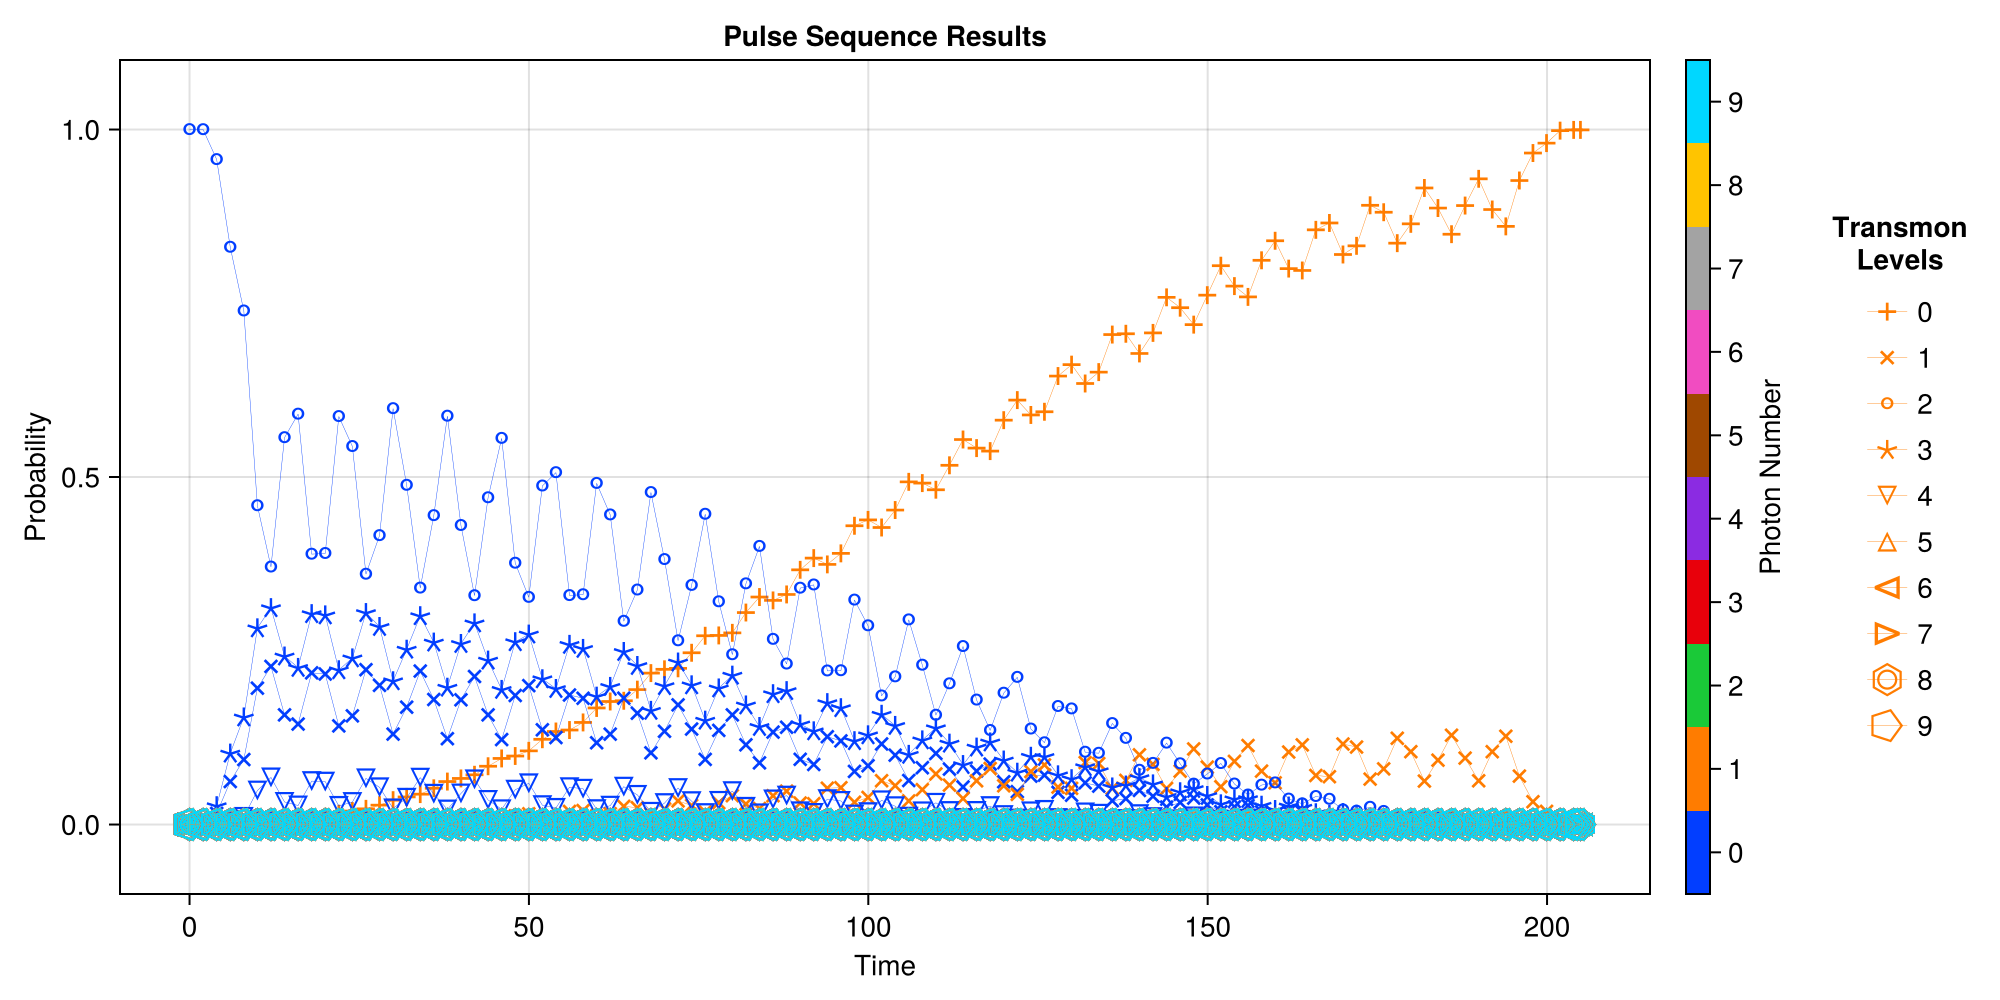

CairoMakie.Screen{IMAGE}


In [123]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

### f1->g2


In [124]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][2][2]*1000))

Target flattop time: 220.8891369047619


In [125]:
ψ1 = Mode2.dressed_states[(2,1)]
ψ2 = Mode2.dressed_states[(0,2)]

freq_d = Mode2.dressed_energies[(0,2)]-Mode2.dressed_energies[(2,1)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)


t_range = [fngnp1_start_time/sqrt(2), fngnp1_start_time/sqrt(2)+fngnp1_ramp_time*2]


optimize_res_f1g2 = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 18:24:27] Info: On Level 1
[2024-11-08 18:24:27] Info: On Step 1: t = 136.68100120299945
[2024-11-08 18:24:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-08 18:24:34] Info: Time Evolution Complete
[2024-11-08 18:24:34] Info: Done with Level_1_step_1
[2024-11-08 18:24:34] Info: Accurace: 0.9800912892903387
[2024-11-08 18:24:34] Info: ------------------------------------------------------------------------------
[2024-11-08 18:24:34] Info: On Step 2: t = 142.49385120299945
[2024-11-08 18:24:34] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 07s (ETA: 0h 00m 00s)
[2024-11-08 18:24:41] Info: Time Evolution Complete
[2024-11-08 18:24:41] Info: Done with Level_1_step_2
[2024-11-08 18:24:41] Info: Accurace: 0.9937372922030601
[2024-11-08 18:24:41] Info: ------------------------------------------------------------------------------
[20

Excessive output truncated after 524308 bytes.

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 148.67
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>148.67, "k"=>2, "ramp_time"=>…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.998533
  "freq_d"        => -3.10383

In [126]:
optimize_res_f1g2["pulse_time"]-optimize_res_f1g2["Envelope Args"]["ramp_time"]*2

125.41860432799943

In [127]:
#Mode2.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 148.67
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>148.67, "k"=>2, "ramp_time"=>…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.998533
  "freq_d"        => -3.10383

### f2->g3

In [128]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][2][3]*1000))

In [129]:
ψ1 = Mode2.dressed_states[(2,2)]
ψ2 = Mode2.dressed_states[(0,3)]

freq_d = Mode2.dressed_energies[(0,3)]-Mode2.dressed_energies[(2,2)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(3), fngnp1_start_time/sqrt(3)+fngnp1_ramp_time*2]

optimize_res_f2g3 = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 123.589
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>123.589, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.997613
  "freq_d"        => -3.10343

In [130]:
optimize_res_f2g3["pulse_time"]-optimize_res_f2g3["Envelope Args"]["ramp_time"]*2

100.33717328502748

In [131]:
#Mode2.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 123.589
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>123.589, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.997613
  "freq_d"        => -3.10343

### f3->g4

In [136]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][2][4]*1000))

In [133]:
ψ1 = Mode2.dressed_states[(2,3)]
ψ2 = Mode2.dressed_states[(0,4)]

freq_d = Mode2.dressed_energies[(0,4)]-Mode2.dressed_energies[(2,3)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(4), fngnp1_start_time/sqrt(4)+fngnp1_ramp_time*2]

optimize_res_f3g4 = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 108.637
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>108.637, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.99669
  "freq_d"        => -3.10304

In [134]:
optimize_res_f3g4["pulse_time"]-optimize_res_f3g4["Envelope Args"]["ramp_time"]*2

85.3856659350076

In [135]:
#Mode2.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 108.637
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>108.637, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.99669
  "freq_d"        => -3.10304

## Other Specific Gates

### Special Side Bands

#### f1_2pi_g3

##### Getting Drive Strength and Stark Shift

In [15]:
n1 = 1
n2 = 3

freq1 = Mode2.dressed_energies[(2,n1)]-Mode2.dressed_energies[(0,n1+1)]
freq2 = Mode2.dressed_energies[(2,n2)]-Mode2.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f1_2pi_g3 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.3
println("Required Epsilon: $eps_f1_2pi_g3")

χ: 0.0007848970006136824
m: 1.4142135623730951
n: 1
Required Epsilon: 0.0832508987500375


[2024-11-08 18:41:51] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


[2024-11-08 18:42:12] Info: Done With Floquet Sweep
[2024-11-08 18:42:12] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0007613188025463708	 0.0005267568261410399	 2.0028257671502483


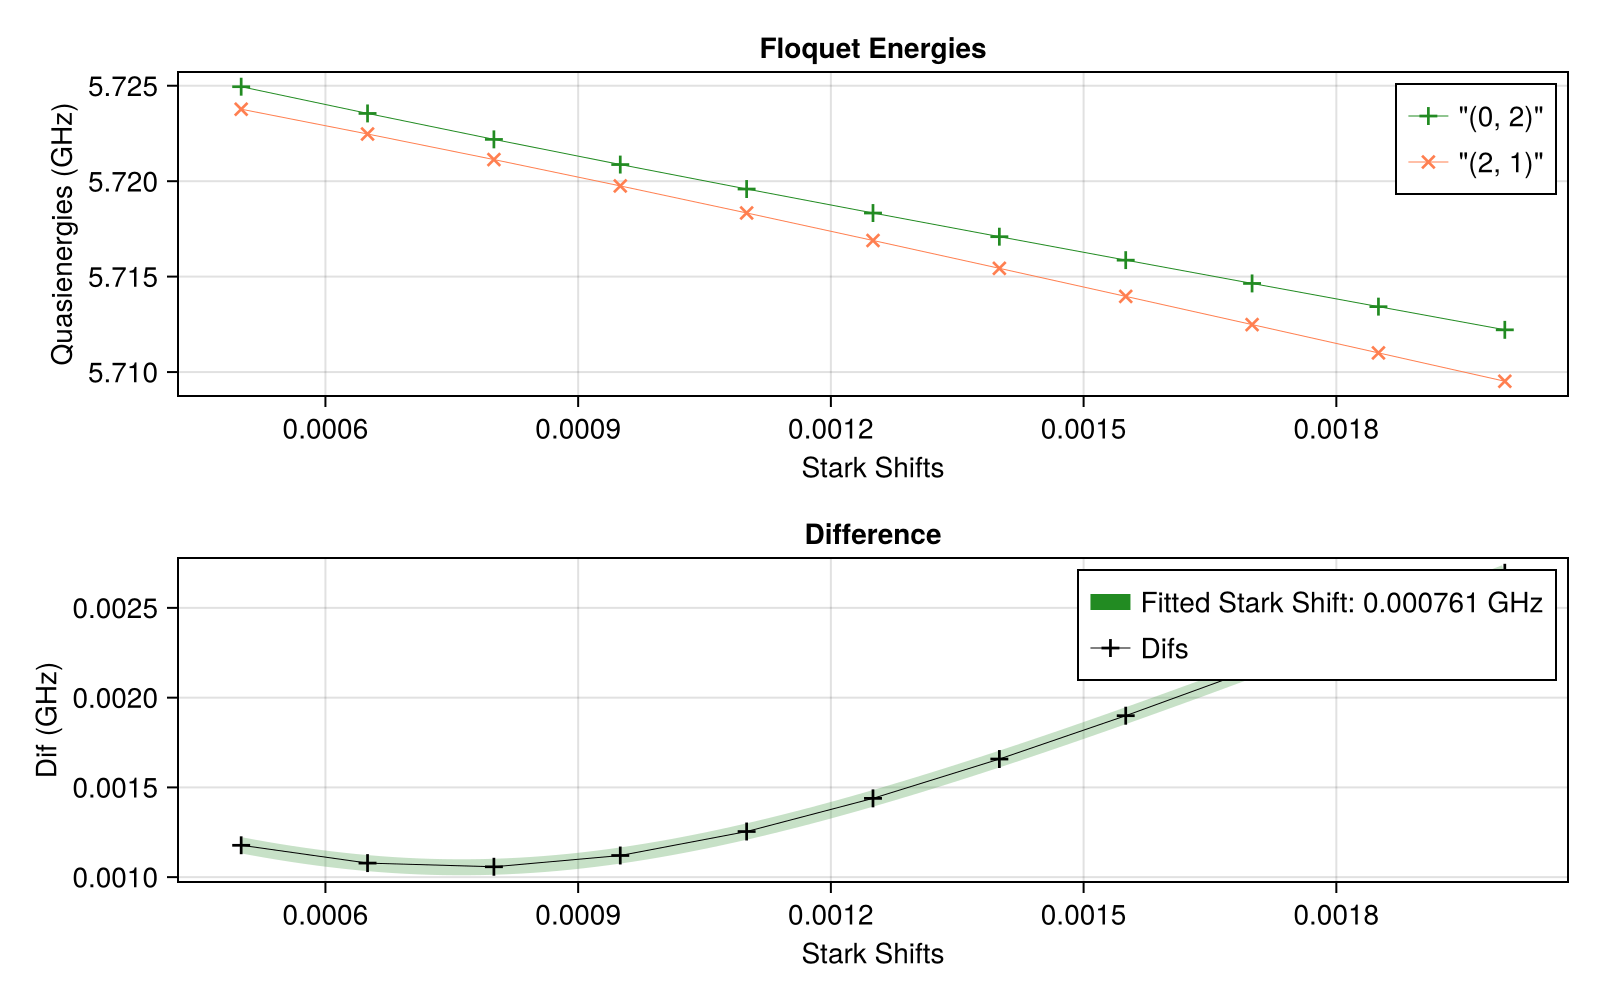

2-element Vector{Float64}:
   0.0007613188025463708
 947.8653719249797

In [16]:
ε = eps_f1_2pi_g3
drive_op = Mode2.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

#stark_shift_list = collect(LinRange(0.0005, 0.002, 11))
stark_shift_list = collect(LinRange(0.0005, 0.002, 11))

stark_shift_res_f0_2pi_g3 = SC.Dynamics.FindStarkShift(Mode2, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [17]:
n2

3

In [18]:
ψ1 = Mode2.dressed_states[(2,n1)]+Mode2.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode2.dressed_states[(0,n1+1)]+Mode2.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)


freq_d = Mode2.dressed_energies[(0,n1+1)]-Mode2.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

check_op = Mode2.dressed_states[(0,n1+1)]*Mode2.dressed_states[(2,n2)]'*2

stark_shift = stark_shift_res_f0_2pi_g3[1]
initial_time = stark_shift_res_f0_2pi_g3[2]

t_range = [initial_time*0.99, initial_time*1.01]

optimize_res_f1g2_2pi_f3g4 = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, eps_f1_2pi_g3, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 7, check_op = check_op);

[2024-11-08 18:42:12] Info: On Level 1
[2024-11-08 18:42:12] Info: On Step 1: t = 938.38671820573
[2024-11-08 18:42:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 42s (ETA: 0h 00m 00s)
[2024-11-08 18:42:55] Info: Time Evolution Complete
[2024-11-08 18:42:55] Info: Done with Level_1_step_1
[2024-11-08 18:42:55] Info: Using Check Op
[2024-11-08 18:42:55] Info: Accurace: 0.9993598958222756
[2024-11-08 18:42:55] Info: ------------------------------------------------------------------------------
[2024-11-08 18:42:55] Info: On Step 2: t = 941.5462694454799
[2024-11-08 18:42:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 43s (ETA: 0h 00m 00s)
[2024-11-08 18:43:39] Info: Time Evolution Complete
[2024-11-08 18:43:39] Info: Done with Level_1_step_2
[2024-11-08 18:43:39] Info: Using Check Op
[2024-11-08 18:43:39] Info: Accurace: 0.9994618631727932
[2024-11-08 18:43:39] Info: 

In [19]:
optimize_res_f1g2_2pi_f3g4["pulse_time"] - optimize_res_f1g2_2pi_f3g4["Envelope Args"]["ramp_time"]*2

921.4544206852298

In [20]:
#Mode2.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 944.706
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>944.706, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0832509
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000761319
  "accuracy"      => 0.999482
  "freq_d"        => -3.10383

In [21]:
ψ = Mode2.dressed_states[(2,1)]+Mode2.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f1g2_2pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["sb_f1g2_2pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T18:48:49.463
It is being saved at: Data/
[2024-11-08 18:48:49] Info: Running operator sb_f1g2_2pi_f3g4
[2024-11-08 18:48:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 41s (ETA: 0h 00m 00s)
[2024-11-08 18:49:30] Info: Time Evolution Complete
[2024-11-08 18:49:30] Info: Saving Steps
[2024-11-08 18:49:37] Info: Done with Step_1
[2024-11-08 18:49:37] Info: Done With Running Sequence
[2024-11-08 18:49:37] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.19998, 0.39996, 0.59994, 0.79992, 0.9999, 1.19988, 1.3…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [22]:
EVs_Dict = SC.Utils.Get_EVs(res_f1g2_2pi_f3g4["states"], proj_dict);

[2024-11-08 18:49:42] Info: Making Plot


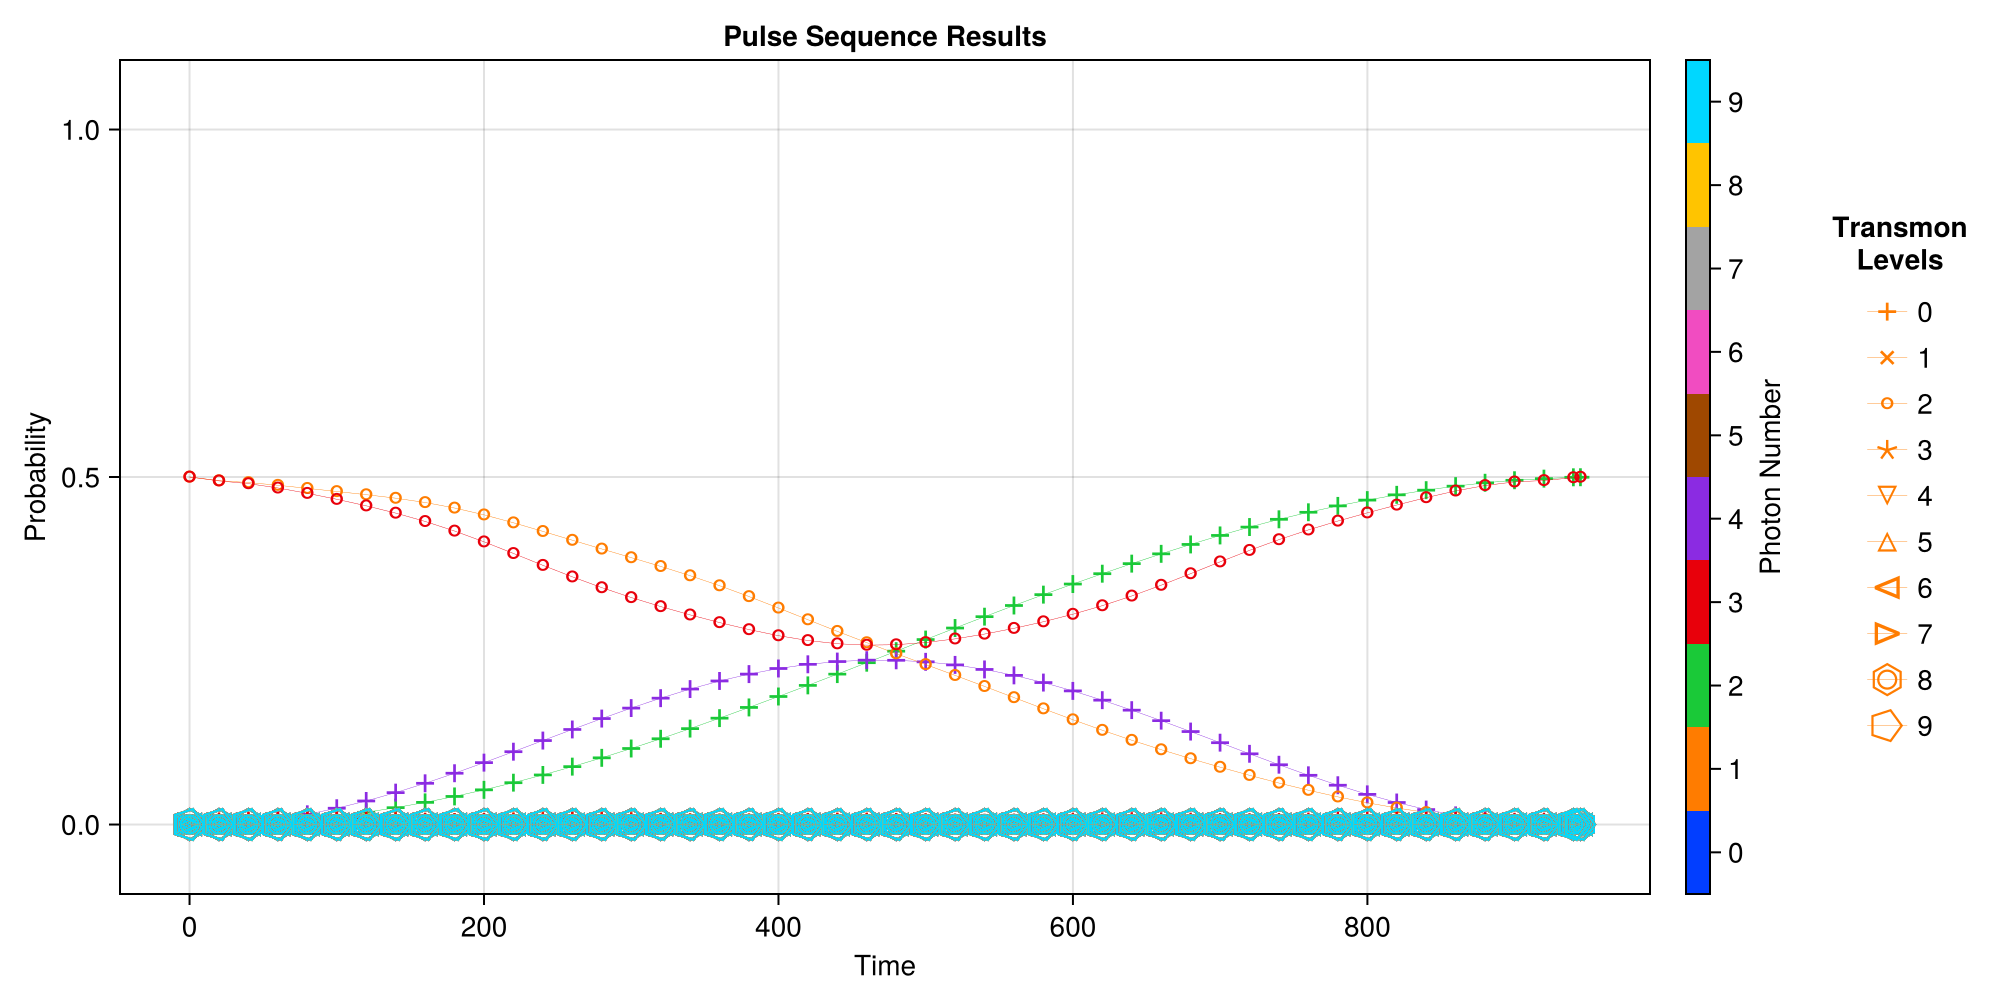

CairoMakie.Screen{IMAGE}


In [23]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, res_f1g2_2pi_f3g4["times"], EVs_Dict, plot_every = 100)

In [24]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,2)][end])

0.49979117254934646 + 4.706245818708166e-17im
0.4996905168282355 + 6.065084884910372e-17im


#### f0_4pi_g3

##### Getting Drive Strength and Stark Shift

In [26]:
n1 = 0
n2 = 3

freq1 = Mode2.dressed_energies[(2,n1)]-Mode2.dressed_energies[(0,n1+1)]
freq2 = Mode2.dressed_energies[(2,n2)]-Mode2.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f0g1_4pi_f3g4 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.45
println("Required Epsilon: $eps_f0g1_4pi_f3g4")

χ: 0.001177480925420582
m: 2.0000000000000004
n: 2
Required Epsilon: 0.07647962954143757


[2024-11-08 18:55:07] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


[2024-11-08 18:55:29] Info: Done With Floquet Sweep
[2024-11-08 18:55:29] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0006433530530826274	 0.0003423902156711056	 2.002387126418146


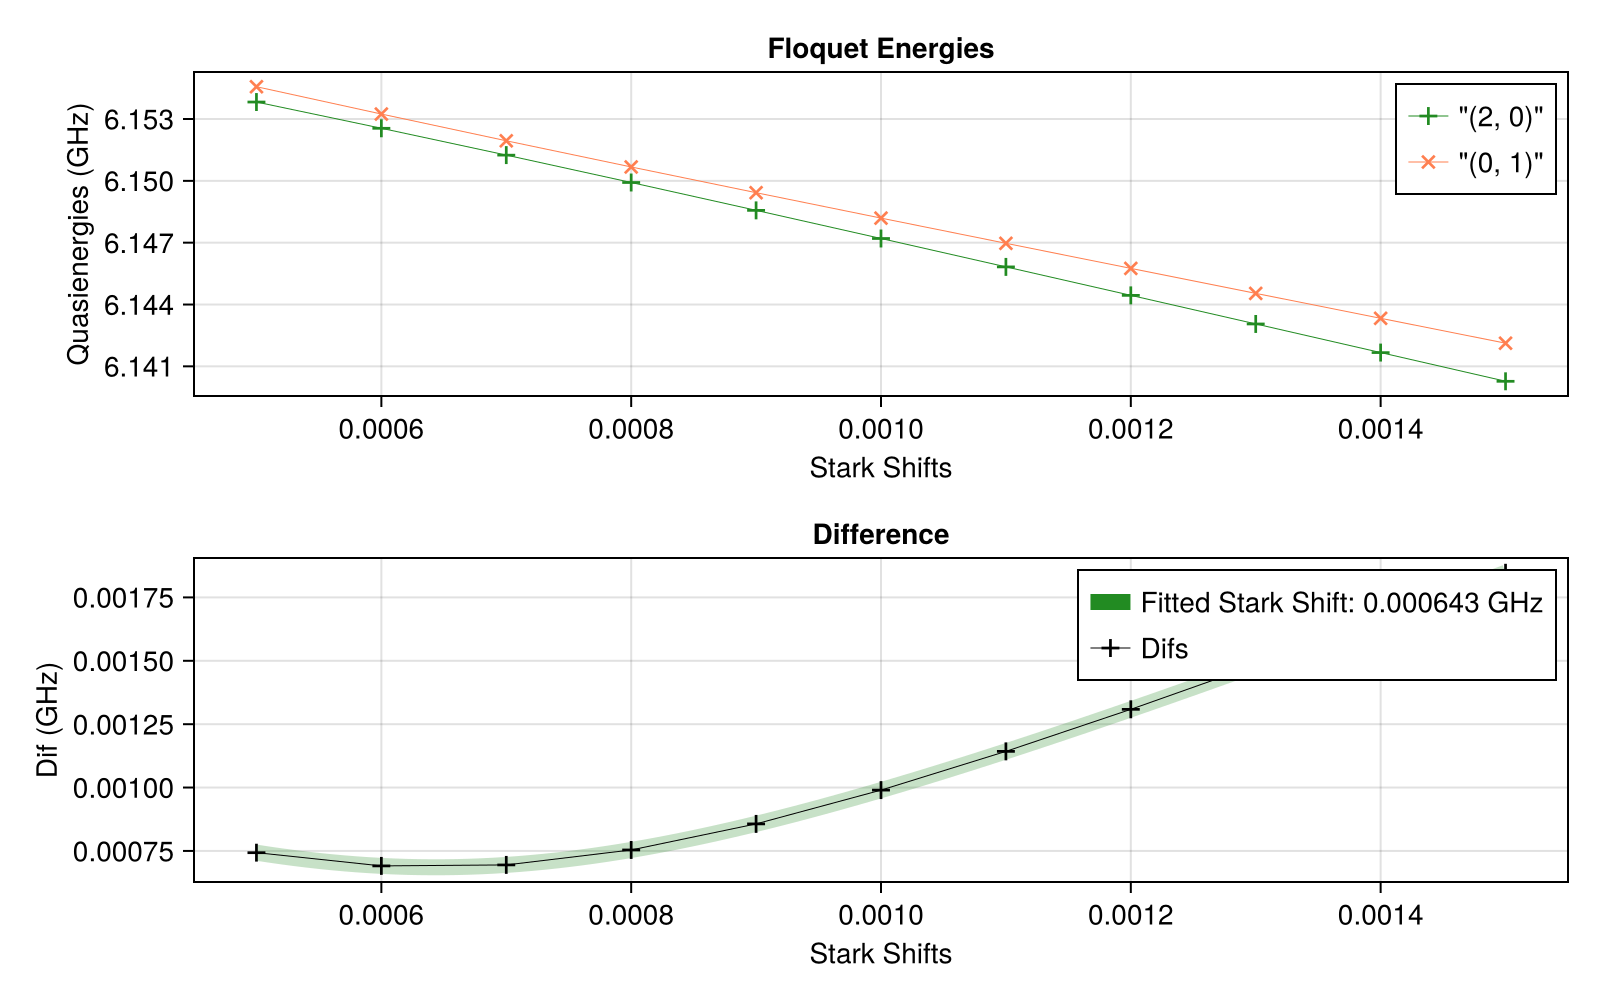

2-element Vector{Float64}:
    0.0006433530530826274
 1458.5811947459163

In [31]:
ε = eps_f0g1_4pi_f3g4
drive_op = Mode2.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

stark_shift_list = collect(LinRange(0.0005, 0.0015, 11))

stark_shift_res_f0g1_4pi_f3g4 = SC.Dynamics.FindStarkShift(Mode2, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [32]:
ψ1 = Mode2.dressed_states[(2,n1)]+Mode2.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode2.dressed_states[(0,n1+1)]+Mode2.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d = Mode2.dressed_energies[(0,n1+1)]-Mode2.dressed_energies[(2, n1)]

check_op = 2*Mode2.dressed_states[(0,n1+1)]*Mode2.dressed_states[(2,n2)]'

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

stark_shift = stark_shift_res_f0g1_4pi_f3g4[1]
initial_time = stark_shift_res_f0g1_4pi_f3g4[2]

ν = abs((stark_shift+freq_d))
t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f0g1_4pi_f3g4 = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, eps_f0g1_4pi_f3g4, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 2, check_op = check_op)

[2024-11-08 18:55:29] Info: On Level 1
[2024-11-08 18:55:29] Info: On Step 1: t = 1458.5811947459163
[2024-11-08 18:55:29] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 11s (ETA: 0h 00m 00s)
[2024-11-08 18:56:41] Info: Time Evolution Complete
[2024-11-08 18:56:41] Info: Done with Level_1_step_1
[2024-11-08 18:56:41] Info: Using Check Op
[2024-11-08 18:56:41] Info: Accurace: 0.9986803501131906
[2024-11-08 18:56:41] Info: ------------------------------------------------------------------------------
[2024-11-08 18:56:41] Info: On Step 2: t = 1481.8325947459164
[2024-11-08 18:56:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 15s (ETA: 0h 00m 00s)
[2024-11-08 18:57:57] Info: Time Evolution Complete
[2024-11-08 18:57:57] Info: Done with Level_1_step_2
[2024-11-08 18:57:57] Info: Using Check Op
[2024-11-08 18:57:57] Info: Accurace: 0.999820378239168
[2024-11-08 18:57:57] Inf

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [33]:
#Mode2.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [34]:
ψ = Mode2.dressed_states[(2,0)]+Mode2.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f0g1_4pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["sb_f0g1_4pi_f3g4"], Return = true, clean_up = true, spns = 1)

The Name for this run is: Operator_Sequence_2024-11-08T18:58:08.288
It is being saved at: Data/
[2024-11-08 18:58:08] Info: Running operator sb_f0g1_4pi_f3g4
[2024-11-08 18:58:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 03s (ETA: 0h 00m 00s)
[2024-11-08 18:59:12] Info: Time Evolution Complete
[2024-11-08 18:59:12] Info: Saving Steps
[2024-11-08 18:59:12] Info: Done with Step_1
[2024-11-08 18:59:12] Info: Done With Running Sequence
[2024-11-08 18:59:12] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.999887, 1.99977, 2.99966, 3.99955, 4.99944, 5.99932, 6…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [35]:
EVs_Dict = SC.Utils.Get_EVs(res_f0g1_4pi_f3g4["states"], proj_dict);

[2024-11-08 18:59:13] Info: Making Plot


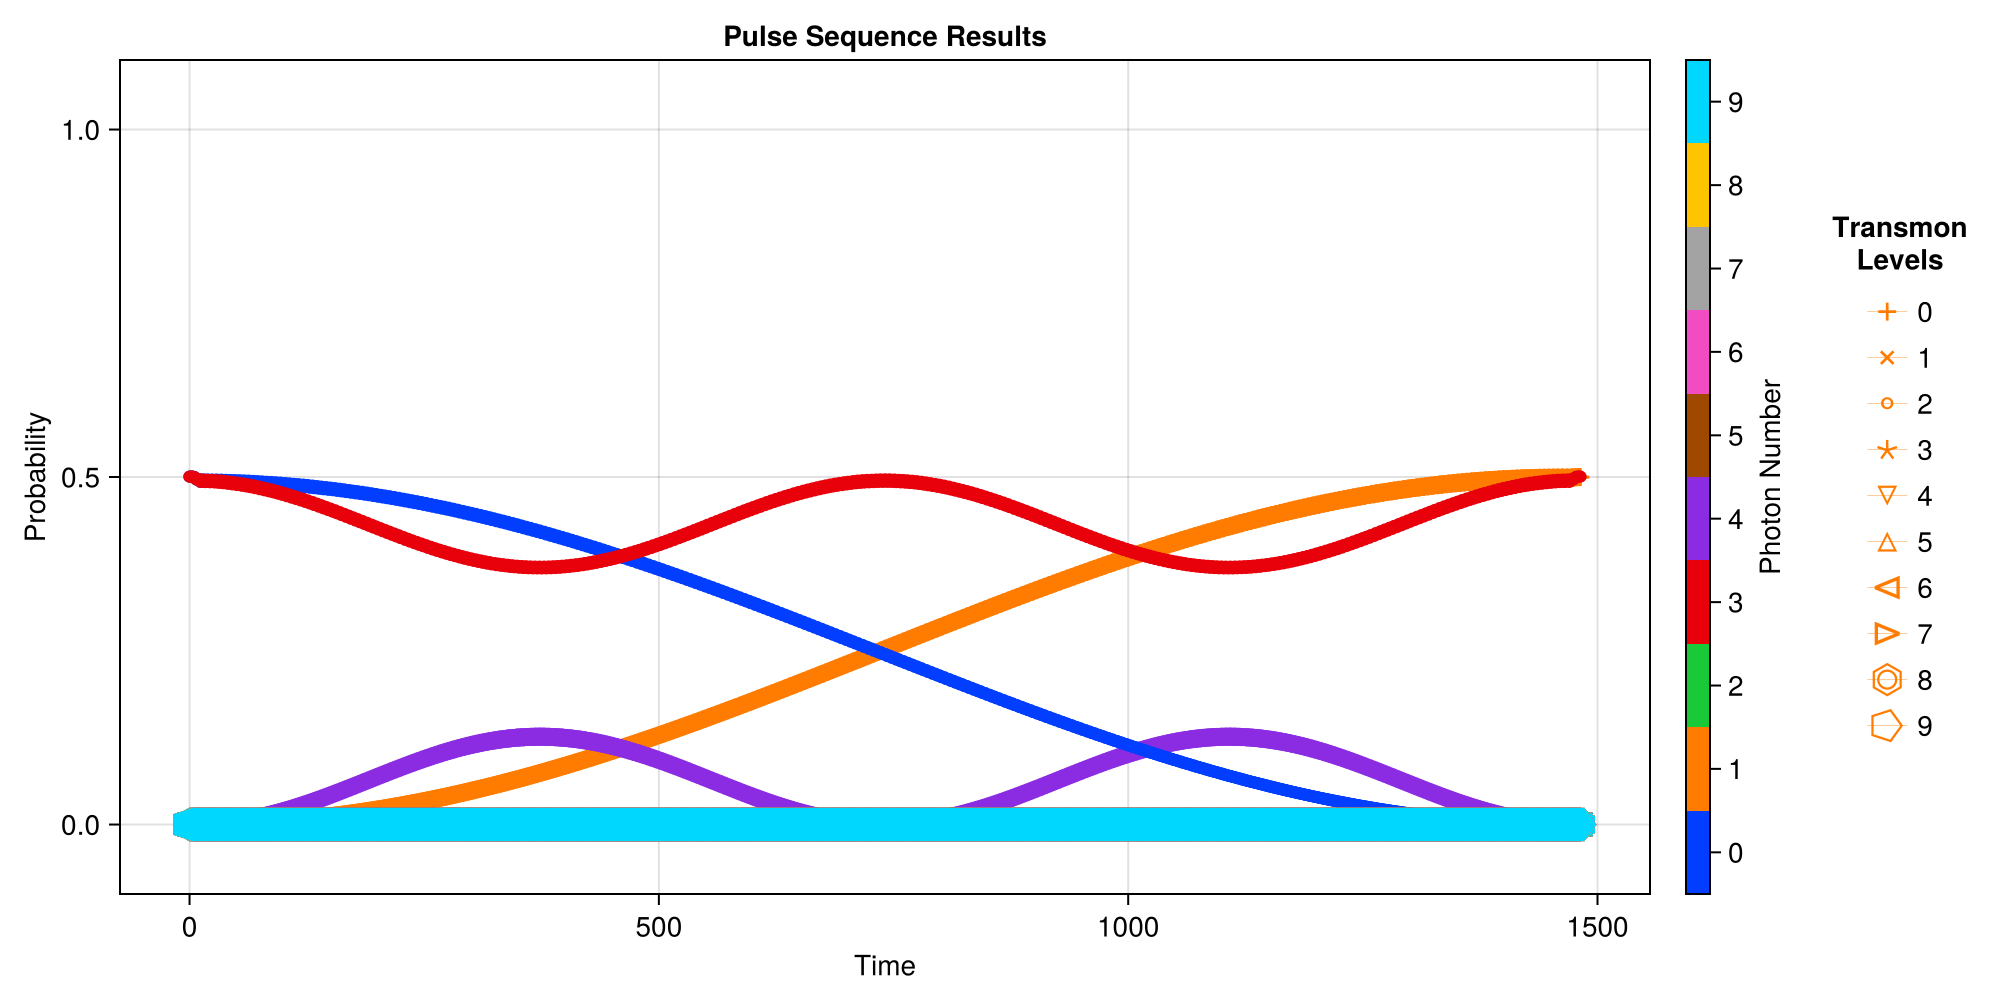

CairoMakie.Screen{IMAGE}


In [36]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, res_f0g1_4pi_f3g4["times"], EVs_Dict)

In [37]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,1)][end])

0.4999974818391036 + 3.209912380096676e-17im
0.4998153296675962 + 8.967827678057819e-17im


#### Half Sideband $|f1\rangle \to |f1\rangle+|g2\rangle$

In [39]:
Mode2.Stuff["op_drive_params"]["sb_f1g2"]["pulse_time"]

148.67000432799944

In [53]:
starting_args = deepcopy(Mode2.Stuff["op_drive_params"]["sb_f1g2"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]

ψ1 = Mode2.dressed_states[(2,1)]
ψ2 = Mode2.dressed_states[(2,1)] + Mode2.dressed_states[(0,2)]
ψ2 = ψ2/sqrt(2)

proj_op = Mode2.dressed_states[(2,1)]*Mode2.dressed_states[(0,2)]'
op = 2*proj_op# proj_dict[(2,1)]+proj_dict[(0,2)]


t_range = [69.8, 70.2]
t_range = [70.8, 71.2]
t_range = [60, 88]
t_range = [starting_args["pulse_time"]*0.5, starting_args["pulse_time"]*0.7]


optimize_res_half_f1g2 = SC.Dynamics.OptimizePulse(Mode2, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 25, check_op = op)

[2024-11-08 19:02:02] Info: On Level 1
[2024-11-08 19:02:02] Info: On Step 1: t = 74.33500216399972
[2024-11-08 19:02:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:02:07] Info: Time Evolution Complete
[2024-11-08 19:02:07] Info: Done with Level_1_step_1
[2024-11-08 19:02:07] Info: Using Check Op
[2024-11-08 19:02:07] Info: Accurace: 0.9903045931640259
[2024-11-08 19:02:07] Info: ------------------------------------------------------------------------------
[2024-11-08 19:02:07] Info: On Step 2: t = 75.57391886673305
[2024-11-08 19:02:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 19:02:11] Info: Time Evolution Complete
[2024-11-08 19:02:11] Info: Done with Level_1_step_2
[2024-11-08 19:02:11] Info: Using Check Op
[2024-11-08 19:02:11] Info: Accurace: 0.9938610397870073
[2024-11-08 19:02:11] Info

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [54]:
#Mode2.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
if GLOBAL_SAVE_CALIBRATE | false
    Mode2.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [55]:
ψ = Mode2.dressed_states[(2,1)]
res_half_f1g2 = SC.Dynamics.RunPulseSequence(Mode2, ψ, ["sb_half_f1g2"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T19:03:32.612
It is being saved at: Data/
[2024-11-08 19:03:32] Info: Running operator sb_half_f1g2
[2024-11-08 19:03:32] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:03:36] Info: Time Evolution Complete
[2024-11-08 19:03:36] Info: Saving Steps
[2024-11-08 19:03:37] Info: Done with Step_1
[2024-11-08 19:03:37] Info: Done With Running Sequence
[2024-11-08 19:03:37] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199825, 0.399651, 0.599476, 0.799301, 0.999126, 1.1989…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [56]:
EVs_Dict = SC.Utils.Get_EVs(res_half_f1g2["states"], proj_dict);

[2024-11-08 19:03:38] Info: Making Plot


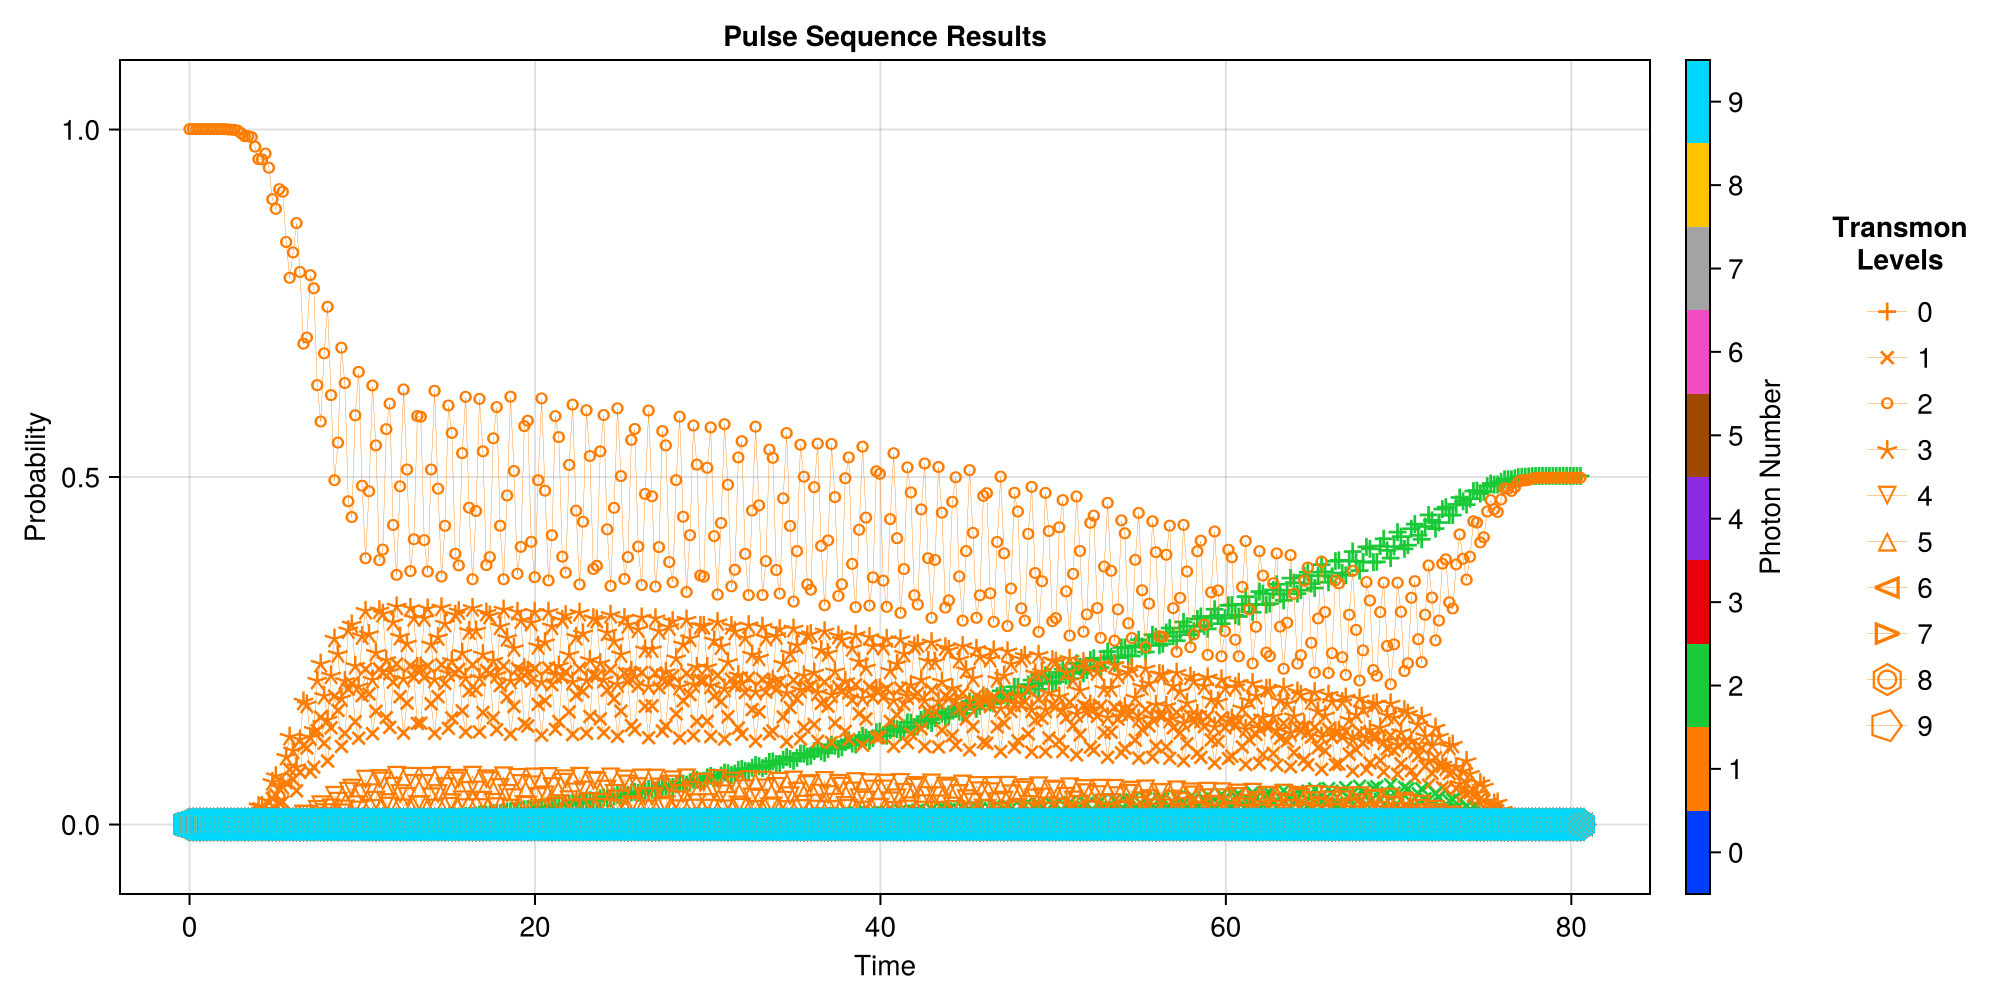

CairoMakie.Screen{IMAGE}


In [57]:
SC.Dynamics.PlotSingleModeEvolution(Mode2, res_half_f1g2["times"], EVs_Dict)

In [58]:
println(EVs_Dict[(2,1)][end])
println(EVs_Dict[(0,2)][end])

0.49842784624199354 + 3.047257166760866e-18im
0.5015715525412404 - 3.656046931258164e-17im
